# Análisis de Propagación de Spikes: Barrido 2D (K, rate_hz)

## Objetivo

Estudiar las probabilidades de activación de vecinos y el firing rate en función de:
- **K (acoplamiento recurrente)**: Factor de escalado de pesos sinápticos
- **rate_hz (input externo)**: Tasa de estímulo talámico

## Estrategia

1. **Barrido 2D**: Simular todas las combinaciones (K, rate_hz) → obtener (FR, P, σ)
2. **Matching por FR**: Para cada (K≠0, FR_target), encontrar K=0 con FR≈FR_target
3. **Contribución de red**: ΔP = P_coupled - P_baseline (mismo FR, diferente origen)
4. **Visualización**: Heatmaps, cortes 1D, análisis de ΔP(K, FR)

## Hipótesis

- FR ≈ a·rate_hz (relación casi lineal)
- K=0 define actividad espúrea (baseline)
- ΔP(K>0) captura la dinámica de red pura

---

## 1. Setup y Configuración

In [1]:
# =============================================================================
# 1. SETUP E IMPORTS
# =============================================================================
import os
import sys
import gzip  # <--- NUEVO: Imprescindible para el Smart Save (.pkl.gz)
import pickle
from pathlib import Path

# Navegación al directorio raíz del proyecto (Lógica robusta)
# Busca si estamos dentro de subcarpetas y sube hasta encontrar 'src'
current_path = Path.cwd()
if current_path.name == 'two_populations':
    os.chdir('../..')
elif not (current_path / 'src').exists():
    # Intento de autodescubrimiento del root si no estamos en 'two_populations'
    # Busca hacia arriba dónde está la carpeta 'src'
    for parent in current_path.parents:
        if (parent / 'src').exists():
            os.chdir(parent)
            break

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from brian2 import *
from datetime import datetime
from collections import defaultdict
from tqdm.auto import tqdm
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from loguru import logger

# Imports del proyecto
# Aseguramos que la raíz está en el path de Python
if str(Path.cwd()) not in sys.path:
    sys.path.append(str(Path.cwd()))

from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results
from src.two_populations.helpers.logger import setup_logger

# Configurar logger (Tu configuración original)
logger = setup_logger(
    experiment_name="spike_propagation_analysis", # Pequeño cambio en nombre para diferenciar del sweep
    console_level="INFO",
    file_level="DEBUG",
    log_to_file=False
)

logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Estilo de plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
# Ajuste extra para legibilidad en análisis
plt.rcParams.update({'figure.figsize': (12, 8), 'font.size': 12})

/home/tonicoll/.conda/envs/neurophysics/lib/python3.11/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO     | __main__:<module>:53 - Working directory: /home/tonicoll/Projects/izhikevich
INFO     | __main__:<module>:54 - Timestamp: 2026-01-16 15:49:06


## 2. Clase de Análisis de Propagación

In [2]:
# =============================================================================
# PROPAGATION ANALYZER (OPTIMIZED)
# =============================================================================

class PropagationAnalyzer:
    """
    Analiza propagación forward E→X:
    Cuando neurona i dispara, ¿cuántos vecinos j responden en ventana temporal?
    
    Optimizaciones:
    - Búsqueda binaria (searchsorted) para encontrar respuestas en O(log N).
    - Vectorización donde es posible.
    """
    
    def __init__(self, window_ms=5.0, min_weight=0.05, min_spikes=2):
        self.window = window_ms
        self.min_weight = min_weight
        self.min_spikes = min_spikes
        
    def extract_connectivity(self, synapses_intra, Ne, target='all', verbose=False):
        """
        Extrae grafo de conectividad E→X desde sinapsis Brian2.
        """
        neighbors = defaultdict(list)
        weights = {}
        
        # Acceso rápido a arrays de Brian2
        pre_indices = np.array(synapses_intra.i)
        post_indices = np.array(synapses_intra.j)
        syn_weights = np.array(synapses_intra.w)
        
        # Filtro vectorizado: Solo E→X y peso > threshold
        # Asumimos que Ne separa excitatorias (0..Ne-1) de inhibitorias
        mask = (pre_indices < Ne) & (syn_weights >= self.min_weight)
        
        # 3. Filtro Postsináptico (Opcional)
        if target == 'exc':
            mask &= (post_indices < Ne)
        elif target == 'inh':
            mask &= (post_indices >= Ne)
        
        valid_pre = pre_indices[mask]
        valid_post = post_indices[mask]
        valid_w = syn_weights[mask]
        
        # Construcción del dict (esto es inevitablemente lento en Python pero se hace una vez)
        for pre, post, w in zip(valid_pre, valid_post, valid_w):
            neighbors[int(pre)].append(int(post))
            weights[(int(pre), int(post))] = float(w)
        
        if verbose:
            n_conns = len(valid_pre)
            if neighbors:
                degrees = [len(v) for v in neighbors.values()]
                logger.info(f"E→X connections: {n_conns} (avg degree: {np.mean(degrees):.1f})")
            else:
                logger.warning("No E→X connections found.")
        
        return dict(neighbors), weights
    
    def organize_spike_times(self, spike_times_arr, spike_indices_arr):
        """
        Organiza spikes por neurona.
        """
        spike_dict = defaultdict(list)
        # Zip es rápido, pero para millones de spikes pandas groupby es mejor.
        # Mantendremos zip por simplicidad si no son millones.
        for t, idx in zip(spike_times_arr, spike_indices_arr):
            spike_dict[int(idx)].append(float(t))
        
        # Convertir a numpy arrays ordenados (CRÍTICO para searchsorted)
        spike_dict = {k: np.sort(np.array(v)) for k, v in spike_dict.items()}
        return dict(spike_dict)
    
    def count_responses_vectorized(self, pre_spike_time, post_neuron_spikes):
        """
        Verifica si neurona post respondió en ventana [t, t+window).
        Usa búsqueda binaria: O(log N) vs O(N) de la versión anterior.
        """
        if len(post_neuron_spikes) == 0:
            return False
        
        # Buscamos dónde caería 'pre_spike_time'
        # searchsorted devuelve el índice donde se insertarían los valores manteniendo orden
        t_start = pre_spike_time
        t_end = pre_spike_time + self.window
        
        # Índice del primer spike >= t_start
        idx_start = np.searchsorted(post_neuron_spikes, t_start, side='left')
        
        # Si idx_start está fuera del array, no hay spikes posteriores
        if idx_start >= len(post_neuron_spikes):
            return False
            
        # Comprobamos si el spike encontrado está dentro de la ventana
        # Basta con mirar el spike en idx_start, porque es el primero >= t_start
        first_spike_after = post_neuron_spikes[idx_start]
        
        return first_spike_after < t_end
    
    def analyze(self, spike_dict, neighbors, T_total, warmup=0.0):
        """
        Análisis principal optimizado.
        """
        # Filtrar spikes por warmup (Vectorizado por neurona)
        spike_dict_filtered = {}
        total_spikes = 0
        n_neurons_active = 0
        
        for nid, times in spike_dict.items():
            valid_times = times[times >= warmup]
            if len(valid_times) > 0:
                spike_dict_filtered[nid] = valid_times
                total_spikes += len(valid_times)
                n_neurons_active += 1
                
        T_analysis = T_total - warmup
        if T_analysis <= 0: return {}
        
        ratios_per_spike = []
        activated_counts = []
        per_neuron_stats = {}
        
        total_spikes_analyzed = 0
        neurons_analyzed = 0
        
        # Bucle principal
        for pre_idx, post_neighbors in neighbors.items():
            if pre_idx not in spike_dict_filtered:
                continue
            
            pre_spikes = spike_dict_filtered[pre_idx]
            
            # Filtro de actividad mínima para estadística robusta
            if len(pre_spikes) < self.min_spikes:
                continue
            
            n_neighbors = len(post_neighbors)
            if n_neighbors == 0: continue
            
            neuron_ratios = []
            neuron_activated = []
            
            # Optimización: Pre-fetch de los spikes de los vecinos para no buscarlos en el dict cada vez
            neighbor_spikes_list = [
                spike_dict_filtered[post] 
                for post in post_neighbors 
                if post in spike_dict_filtered
            ]
            
            # Iterar sobre cada spike presináptico
            for spike_time in pre_spikes:
                n_activated = 0
                
                # Comprobar cada vecino (Ahora usando searchsorted)
                for post_spikes in neighbor_spikes_list:
                    if self.count_responses_vectorized(spike_time, post_spikes):
                        n_activated += 1
                
                ratio = n_activated / n_neighbors
                
                ratios_per_spike.append(ratio)
                activated_counts.append(n_activated)
                neuron_ratios.append(ratio)
                neuron_activated.append(n_activated)
                total_spikes_analyzed += 1
            
            # Estadísticas por neurona
            if neuron_ratios:
                per_neuron_stats[pre_idx] = {
                    'n_spikes': len(pre_spikes),
                    'n_neighbors': n_neighbors,
                    'mean_ratio': np.mean(neuron_ratios),
                    'mean_activated': np.mean(neuron_activated)
                }
                neurons_analyzed += 1
        
        # Cálculo final de métricas
        firing_rate = (total_spikes / max(1, n_neurons_active) / T_analysis) * 1000.0
        
        # Convertir a arrays para cálculos numpy seguros
        ratios_per_spike = np.array(ratios_per_spike) if ratios_per_spike else np.array([0.0])
        activated_counts = np.array(activated_counts) if activated_counts else np.array([0.0])
        
        results = {
            'P_transmission': float(np.mean(ratios_per_spike)),
            'P_transmission_std': float(np.std(ratios_per_spike)),
            'sigma': float(np.mean(activated_counts)),
            'sigma_std': float(np.std(activated_counts)),
            'firing_rate': float(firing_rate),
            # Guardamos distribuciones raw si se necesitan para histogramas
            'ratio_distribution': ratios_per_spike, 
            'activated_counts': activated_counts,
            'per_neuron': per_neuron_stats,
            'stats': {
                'n_neurons_analyzed': neurons_analyzed,
                'total_spikes_analyzed': total_spikes_analyzed,
                'total_spikes': total_spikes,
                'n_neurons_active': n_neurons_active,
                'T_analysis': T_analysis
            }
        }
        
        return results

logger.success("PropagationAnalyzer class defined (Optimized Version)")

SUCCESS  | __main__:<module>:206 - PropagationAnalyzer class defined (Optimized Version)


## 3. Cargar Resultados 

In [16]:
# =============================================================================
# 3. CLASE: UNIVERSAL RESULTS LOADER (SMART SAVE ONLY)
# =============================================================================

class UniversalResultsLoader:
    """
    Cargador optimizado para formato 'Smart Save'.
    Espera una carpeta que contenga un 'results.pkl' índice y archivos 'raw_data_*.pkl.gz'.
    """
    def __init__(self):
        self.df = None
        self.config = {}
        self.base_dir = None
        
    def list_sweeps(self, root_dir="results/spike_propagation_2d"):
        """Lista los sweeps compatibles disponibles"""
        root = Path(root_dir)
        if not root.exists():
            logger.warning(f"Directorio no encontrado: {root}")
            return
            
        print(f"--- Sweeps disponibles en {root_dir} ---")
        found = False
        for p in sorted(root.iterdir()):
            if p.is_dir() and (p / "results.pkl").exists():
                print(f"[SMART_SAVE] {p.name}")
                found = True
        
        if not found:
            print("(No se encontraron carpetas de barrido válidas)")

    def load(self, path_to_results):
        """
        Carga el índice de resultados (DataFrame).
        Args:
            path_to_results: Ruta a la carpeta del sweep (ej: 'results/sweep_X')
        """
        path = Path(path_to_results)
        
        # Flexibilidad: Acepta la carpeta o el archivo results.pkl directo
        if path.name == 'results.pkl':
            self.base_dir = path.parent
            file_path = path
        else:
            self.base_dir = path
            file_path = path / 'results.pkl'
            
        if not file_path.exists():
            raise FileNotFoundError(f"No se encontró el índice de resultados: {file_path}")
            
        logger.info(f"Cargando índice: {file_path}")
        
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            
        # Extracción robusta (soporta diccionarios o DataFrames directos)
        if isinstance(data, dict) and 'df_results' in data:
            self.df = data['df_results']
            self.config = data.get('config', {})
        else:
            self.df = pd.DataFrame(data)
            
        # Normalización de columnas (asegurar nombres estándar)
        renames = {'prob': 'P_transmission', 'fr': 'firing_rate'}
        self.df.rename(columns=renames, inplace=True)

        logger.success(f"Dataset cargado: {len(self.df)} simulaciones.")
        return self.df

    def get_raw_data(self, k, rate, trial=0):
        """
        Recupera y descomprime los datos crudos para una simulación específica.
        """
        if self.df is None: 
            logger.error("Primero carga los datos con .load()")
            return None
        
        # 1. Buscar la fila correspondiente
        # Usamos np.isclose para evitar errores de punto flotante (e.g. 0.1 vs 0.1000001)
        try:
            k_mask = np.isclose(self.df.k, k, atol=1e-5)
            r_mask = np.isclose(self.df.rate_hz, rate, atol=1e-5)
            t_mask = (self.df.trial == trial)
            row = self.df[k_mask & r_mask & t_mask]
        except AttributeError as e:
            logger.error(f"El DataFrame no tiene las columnas esperadas (k, rate_hz, trial): {e}")
            return None
        
        if row.empty:
            logger.warning(f"Simulación no encontrada: K={k}, Rate={rate}, Trial={trial}")
            return None
        
        sim_row = row.iloc[0]
        rel_path = sim_row.get('raw_data_file')
        
        if not rel_path:
            logger.warning("Entrada encontrada pero sin ruta de archivo raw.")
            return None
            
        # 2. Reconstruir ruta absoluta (robusto a mover carpetas)
        filename = Path(rel_path).name
        full_path = self.base_dir / filename
        
        if not full_path.exists():
            logger.error(f"Archivo raw perdido en disco: {full_path}")
            return None
            
        # 3. Cargar y Descomprimir
        try:
            with gzip.open(full_path, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            logger.error(f"Error descomprimiendo {filename}: {e}")
            return None

# Instanciar y listar opciones
loader = UniversalResultsLoader()
loader.list_sweeps()

# Cargar el último sweep automáticamente (o cámbialo manualmente)
df_sweep = loader.load('results/spike_propagation_2d/sweep_2d_20260116_025857')
df_sweep

INFO     | __main__:load:51 - Cargando índice: results/spike_propagation_2d/sweep_2d_20260116_025857/results.pkl
SUCCESS  | __main__:load:67 - Dataset cargado: 5200 simulaciones.


--- Sweeps disponibles en results/spike_propagation_2d ---
[SMART_SAVE] sweep_2d_20260115_171249
[SMART_SAVE] sweep_2d_20260115_202834
[SMART_SAVE] sweep_2d_20260116_001143
[SMART_SAVE] sweep_2d_20260116_025857


,k,rate_hz,trial,firing_rate,P_transmission,P_transmission_std,sigma,sigma_std,n_neurons_analyzed,total_spikes,raw_data_file,status
0,0.0,2.0,0,2.616541,0.000000,0.000000,0.000000,0.000000,0,348,results/spike_propagation_2d/sweep_2d_20260116...,success
1,0.0,2.0,1,2.769841,0.000000,0.000000,0.000000,0.000000,0,349,results/spike_propagation_2d/sweep_2d_20260116...,success
2,0.0,2.0,2,2.435714,0.000000,0.000000,0.000000,0.000000,0,341,results/spike_propagation_2d/sweep_2d_20260116...,success
3,0.0,2.0,3,2.425087,0.000000,0.000000,0.000000,0.000000,0,348,results/spike_propagation_2d/sweep_2d_20260116...,success
4,0.0,2.0,4,2.640927,0.000000,0.000000,0.000000,0.000000,0,342,results/spike_propagation_2d/sweep_2d_20260116...,success
...,...,...,...,...,...,...,...,...,...,...,...,...
5195,19.5,14.5,0,45.594857,0.348378,0.147709,34.668395,15.134731,800,159582,results/spike_propagation_2d/sweep_2d_20260116...,success
5196,19.5,14.5,1,45.321429,0.360424,0.149943,35.865964,15.376113,800,158625,results/spike_propagation_2d/sweep_2d_20260116...,success
5197,19.5,14.5,2,46.085714,0.350699,0.146091,34.909784,14.980930,800,161300,results/spike_propagation_2d/sweep_2d_20260116...,success
5198,19.5,14.5,3,45.474857,0.353924,0.148717,35.215250,15.237725,800,159162,results/spike_propagation_2d/sweep_2d_20260116...,success


In [17]:
# =============================================================================
# 3.5. EXTRAER CONFIGURACIÓN AL ENTORNO GLOBAL
# =============================================================================

# Si hemos cargado datos, extraemos la configuración para usarla fácilmente
if loader.df is not None:
    print("Recuperando parámetros del experimento...")
    
    # Extraer diccionarios del loader
    SIM_CONFIG = loader.config.get('SIM_CONFIG', {'dt_ms': 0.1, 'T_ms': 5000, 'warmup_ms': 500})
    NETWORK_PARAMS = loader.config.get('NETWORK_PARAMS', {'Ne': 800})
    PROPAGATION_CONFIG = loader.config.get('PROPAGATION_CONFIG', {'window_ms': 4.0, 'min_weight': 0.05, 'min_spikes': 5})
    
    # Definir variables sueltas críticas
    Ne = NETWORK_PARAMS.get('Ne', 800)
    
    print(f"  -> Ne: {Ne}")
    print(f"  -> Duración: {SIM_CONFIG.get('T_ms')} ms")
    print(f"  -> Ventana Análisis: {PROPAGATION_CONFIG.get('window_ms')} ms")
else:
    print("⚠ No se han cargado datos. Ejecuta loader.load() primero.")

Recuperando parámetros del experimento...
  -> Ne: 800
  -> Duración: 4000 ms
  -> Ventana Análisis: 4.0 ms


## 7. Análisis de Matching por FR

In [18]:
from types import SimpleNamespace

# =============================================================================
# HELPER: PROCESS SIMULATION RESULTS (Clean & Lightweight)
# =============================================================================

def process_simulation_results(sim_data):
    """
    Procesa resultados de simulación para obtener métricas.
    - Elimina dependencia de 'loader'. Usa variables globales (Ne, SIM_CONFIG).
    - Elimina clase interna. Usa SimpleNamespace.
    """
    
    # 1. Configurar Analyzer (Usa config global)
    analyzer = PropagationAnalyzer(
        window_ms=PROPAGATION_CONFIG['window_ms'],
        min_weight=PROPAGATION_CONFIG['min_weight'],
        min_spikes=PROPAGATION_CONFIG['min_spikes']
    )
    
    # 2. Adaptador Rápido para Sinapsis (Dict -> Objeto)
    # Convierte el diccionario {'i': ..., 'w': ...} en un objeto donde se puede hacer obj.i
    syn_obj = SimpleNamespace(**sim_data['synapses'])
    
    # 3. Extraer conectividad
    # Usa la variable global 'Ne' directamente
    neighbors, weights = analyzer.extract_connectivity(
        synapses_intra=syn_obj, 
        Ne=Ne, 
        target='all', 
        verbose=False
    )
    
    # 4. Organizar spikes
    spike_dict = analyzer.organize_spike_times(
        sim_data['spike_times'],
        sim_data['spike_indices']
    )
    
    # 5. Analizar propagación
    # Usa la variable global 'SIM_CONFIG' directamente
    prop_results = analyzer.analyze(
        spike_dict=spike_dict,
        neighbors=neighbors,
        T_total=SIM_CONFIG['T_ms'],
        warmup=SIM_CONFIG['warmup_ms']
    )
    
    # 6. Empaquetar resultados
    # Nota: Asumimos estructura Smart Save donde params están anidados
    params = sim_data.get('params', sim_data) # Fallback por seguridad
    
    return {
        'k': params['k'],
        'rate_hz': params.get('rate', params.get('rate_hz')), # Compatible con 'rate' o 'rate_hz'
        'trial': params['trial'],
        'firing_rate': prop_results['firing_rate'],
        'P_transmission': prop_results['P_transmission'],
        'P_transmission_std': prop_results['P_transmission_std'],
        'sigma': prop_results['sigma'],
        'sigma_std': prop_results['sigma_std'],
        'n_neurons_analyzed': prop_results['stats']['n_neurons_analyzed'],
        'total_spikes': prop_results['stats']['total_spikes']
    }

logger.success("Helper function 'process_simulation_results' defined (Lightweight)")
    
# =============================================================================
# NETWORK CONTRIBUTION FIX
# =============================================================================

def compute_network_contribution_fixed(df_sweep):
    """Versión corregida que maneja baseline = 0"""
    df_baseline = df_sweep[df_sweep['k'] == 0].copy()
    df_coupled = df_sweep[df_sweep['k'] > 0].copy()
    
    logger.info(f"Baseline points: {len(df_baseline)}")
    logger.info(f"Coupled points: {len(df_coupled)}")
    
    df_merged = df_coupled.merge(
        df_baseline[['rate_hz', 'trial', 'P_transmission', 'sigma', 'firing_rate']],
        on=['rate_hz', 'trial'],
        suffixes=('', '_baseline')
    )
    
    df_merged['delta_P'] = df_merged['P_transmission'] - df_merged['P_transmission_baseline']
    df_merged['delta_sigma'] = df_merged['sigma'] - df_merged['sigma_baseline']
    
    threshold = 1e-6
    df_merged['fold_change_P'] = np.where(
        df_merged['P_transmission_baseline'] > threshold,
        df_merged['P_transmission'] / df_merged['P_transmission_baseline'],
        np.nan
    )
    
    df_merged['relative_increase_P'] = df_merged['delta_P'] / (df_merged['P_transmission_baseline'] + 0.01)
    df_merged['relative_increase_sigma'] = df_merged['delta_sigma'] / (df_merged['sigma_baseline'] + 0.1)
    
    df_contribution = df_merged.groupby('k').agg({
        'delta_P': ['mean', 'std'],
        'delta_sigma': ['mean', 'std'],
        'relative_increase_P': ['mean', 'std'],
        'relative_increase_sigma': ['mean', 'std']
    }).round(4)
    
    return df_contribution, df_merged, df_baseline

# Ejecutar y asignar variables
df_contrib, df_network_contribution, df_baseline = compute_network_contribution_fixed(df_sweep)

print("\n" + "=" * 80)
print("NETWORK CONTRIBUTION (FIXED)")
print("=" * 80)
print(df_contrib)
print("=" * 80)

SUCCESS  | __main__:<module>:66 - Helper function 'process_simulation_results' defined (Lightweight)
INFO     | __main__:compute_network_contribution_fixed:77 - Baseline points: 130
INFO     | __main__:compute_network_contribution_fixed:78 - Coupled points: 5070



NETWORK CONTRIBUTION (FIXED)
     delta_P         delta_sigma         relative_increase_P          \
        mean     std        mean     std                mean     std   
k                                                                      
0.5   0.0209  0.0186      1.8753  1.6692              2.0865  1.8603   
1.0   0.0224  0.0198      2.1209  1.8744              2.2370  1.9761   
1.5   0.0251  0.0214      2.4235  2.0623              2.5121  2.1354   
2.0   0.0288  0.0239      2.8024  2.3283              2.8778  2.3937   
2.5   0.0345  0.0271      3.3781  2.6535              3.4507  2.7142   
3.0   0.0440  0.0316      4.3131  3.0998              4.3950  3.1592   
3.5   0.0567  0.0370      5.5772  3.6400              5.6711  3.7016   
4.0   0.0710  0.0428      6.9913  4.2154              7.0969  4.2836   
4.5   0.0870  0.0498      8.5792  4.9106              8.7021  4.9808   
5.0   0.1018  0.0572     10.0554  5.6491             10.1806  5.7250   
5.5   0.1219  0.0618     12.0433  

In [19]:
# # =============================================================================
# # 7. OPTIMIZACIÓN DE PARÁMETROS DE ANÁLISIS (SENSITIVITY CHECK)
# # =============================================================================

# def optimize_analysis_params(k_target, rate_target, n_trials_check=2):
#     """
#     Evalúa cómo cambian las métricas al variar los parámetros de análisis.
#     Usa solo los primeros 'n_trials_check' para ser rápido.
#     """
#     print(f"--- Optimizando parámetros para K={k_target}, Rate={rate_target} ---")
    
#     # 1. Cargar datos crudos de unos pocos trials
#     raw_samples = []
#     for t in range(n_trials_check):
#         raw = loader.get_raw_data(k_target, rate_target, t)
#         if raw: raw_samples.append(raw)
        
#     if not raw_samples: return

#     # --- EXPERIMENTO A: Sensibilidad a la Ventana Temporal ---
#     windows = np.linspace(1.0, 15.0, 15) # Probar de 1 a 15 ms
#     p_means = []
#     p_stds = []
    
#     for w in tqdm(windows, desc="Testing Windows"):
#         # Re-inicializar analyzer con nueva ventana
#         analyzer = PropagationAnalyzer(window_ms=w, min_weight=0.05, min_spikes=2)
        
#         trial_ps = []
#         for raw in raw_samples:
#             # Reconstruir objetos necesarios (esto es rápido)
#             # Nota: Necesitamos reconstruir 'neighbors' si no los guardamos en raw.
#             # Asumimos que raw tiene 'synapses' o que usamos una aproximación.
#             # SI NO TIENES SINAPSIS EN RAW (Smart Save), esto es un reto.
#             # SOLUCIÓN: Usar la conectividad promedio o estimarla si no se guardó.
#             pass 
#             # ... (Ver nota abajo sobre Sinapsis) ...

#     # NOTA CRÍTICA:
#     # Para re-analizar, necesitas la conectividad (quién conecta con quién).
#     # En 'Smart Save' ligero, NO guardamos la matriz de sinapsis completa (pesa mucho).
#     # ¿Guardaste 'synapses' en tu raw_payload? Vamos a verificarlo.
    
#     # Si NO las guardaste, no puedes re-calcular P_transmission exacto post-hoc.
#     # Si SÍ las guardaste (en la versión High-Fidelity Trial 0), entonces puedes usar el Trial 0.

In [20]:
# =============================================================================
# DIAGNOSTIC ANALYSIS
# =============================================================================

print("\n" + "=" * 80)
print("DIAGNOSTIC CHECKS")
print("=" * 80)

# 1. Distribución de zeros
zero_P = (df_sweep['P_transmission'] == 0).sum()
zero_sigma = (df_sweep['sigma'] == 0).sum()
zero_neurons = (df_sweep['n_neurons_analyzed'] == 0).sum()

print(f"\nZERO VALUES:")
print(f"  P_transmission = 0:     {zero_P}/{len(df_sweep)} ({100*zero_P/len(df_sweep):.1f}%)")
print(f"  sigma = 0:              {zero_sigma}/{len(df_sweep)} ({100*zero_sigma/len(df_sweep):.1f}%)")
print(f"  n_neurons_analyzed = 0: {zero_neurons}/{len(df_sweep)} ({100*zero_neurons/len(df_sweep):.1f}%)")

# 2. Por condición de K
print(f"\nZEROS BY K VALUE:")
for k_val in sorted(df_sweep['k'].unique()):
    subset = df_sweep[df_sweep['k'] == k_val]
    zero_p_k = (subset['P_transmission'] == 0).sum()
    print(f"  K={k_val:5.1f}: {zero_p_k:3d}/{len(subset):3d} zeros ({100*zero_p_k/len(subset):5.1f}%)")

# 3. Por rate
print(f"\nZEROS BY RATE:")
for rate_val in sorted(df_sweep['rate_hz'].unique()):
    subset = df_sweep[df_sweep['rate_hz'] == rate_val]
    zero_p_r = (subset['P_transmission'] == 0).sum()
    print(f"  rate={rate_val:5.1f}Hz: {zero_p_r:3d}/{len(subset):3d} zeros ({100*zero_p_r/len(subset):5.1f}%)")

# 4. Trial consistency (CV)
print(f"\nTRIAL CONSISTENCY (Coefficient of Variation):")
for metric in ['firing_rate', 'P_transmission', 'sigma']:
    cv_values = []
    for k_val in df_sweep['k'].unique():
        for rate_val in df_sweep['rate_hz'].unique():
            subset = df_sweep[(df_sweep['k'] == k_val) & (df_sweep['rate_hz'] == rate_val)]
            if len(subset) > 1 and subset[metric].mean() > 0:
                cv = subset[metric].std() / subset[metric].mean()
                cv_values.append(cv)
    
    if len(cv_values) > 0:
        print(f"  {metric:20s}: CV = {np.mean(cv_values):.4f} ± {np.std(cv_values):.4f}")

print("\n" + "=" * 80)


DIAGNOSTIC CHECKS

ZERO VALUES:
  P_transmission = 0:     580/5200 (11.2%)
  sigma = 0:              580/5200 (11.2%)
  n_neurons_analyzed = 0: 568/5200 (10.9%)

ZEROS BY K VALUE:
  K=  0.0: 130/130 zeros (100.0%)
  K=  0.5:  28/130 zeros ( 21.5%)
  K=  1.0:  29/130 zeros ( 22.3%)
  K=  1.5:  23/130 zeros ( 17.7%)
  K=  2.0:  26/130 zeros ( 20.0%)
  K=  2.5:  27/130 zeros ( 20.8%)
  K=  3.0:  28/130 zeros ( 21.5%)
  K=  3.5:  25/130 zeros ( 19.2%)
  K=  4.0:  25/130 zeros ( 19.2%)
  K=  4.5:  27/130 zeros ( 20.8%)
  K=  5.0:  27/130 zeros ( 20.8%)
  K=  5.5:  22/130 zeros ( 16.9%)
  K=  6.0:  20/130 zeros ( 15.4%)
  K=  6.5:  20/130 zeros ( 15.4%)
  K=  7.0:  19/130 zeros ( 14.6%)
  K=  7.5:  16/130 zeros ( 12.3%)
  K=  8.0:  13/130 zeros ( 10.0%)
  K=  8.5:  11/130 zeros (  8.5%)
  K=  9.0:  10/130 zeros (  7.7%)
  K=  9.5:   7/130 zeros (  5.4%)
  K= 10.0:   9/130 zeros (  6.9%)
  K= 10.5:   7/130 zeros (  5.4%)
  K= 11.0:   6/130 zeros (  4.6%)
  K= 11.5:   4/130 zeros (  3.1%)
  K

  firing_rate         : CV = 0.0301 ± 0.0977
  P_transmission      : CV = 0.0867 ± 0.2993
  sigma               : CV = 0.0867 ± 0.2994



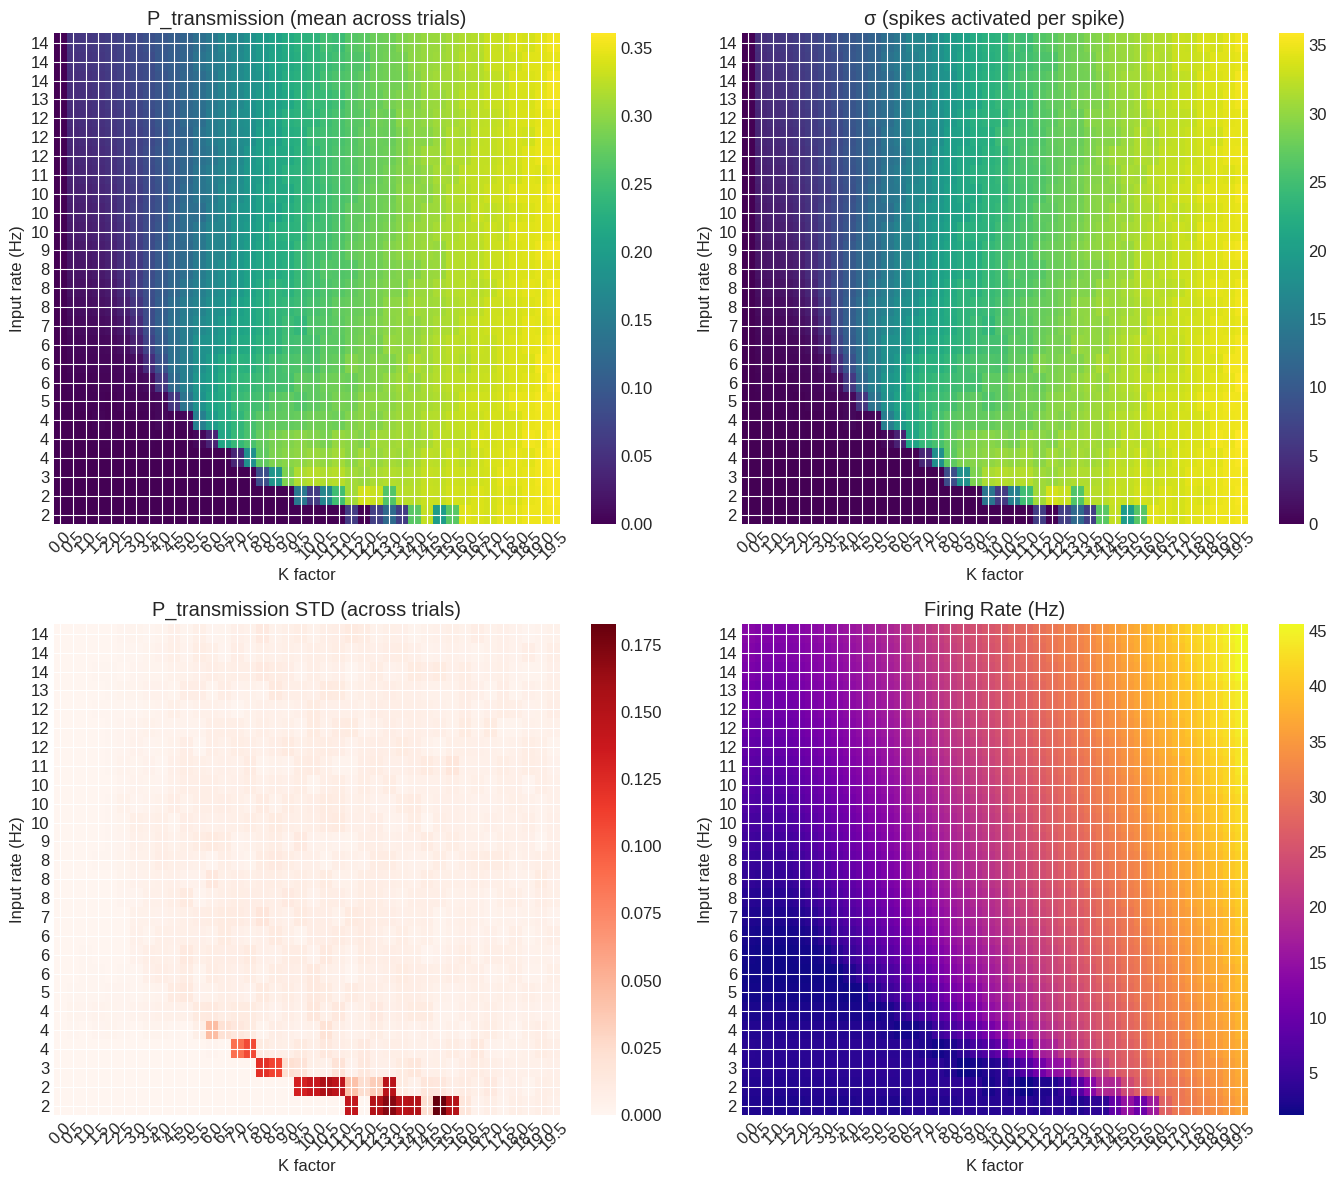

SUCCESS  | __main__:<module>:74 - Heatmaps generated


In [21]:
# =============================================================================
# VISUALIZATION: 2D HEATMAPS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Preparar datos agregados
df_agg = df_sweep.groupby(['k', 'rate_hz']).agg({
    'P_transmission': ['mean', 'std'],
    'sigma': ['mean', 'std'],
    'firing_rate': 'mean'
}).reset_index()

df_agg.columns = ['k', 'rate_hz', 'P_mean', 'P_std', 'sigma_mean', 'sigma_std', 'FR_mean']

# Crear pivot tables
pivot_P = df_agg.pivot(index='rate_hz', columns='k', values='P_mean')
pivot_sigma = df_agg.pivot(index='rate_hz', columns='k', values='sigma_mean')
pivot_P_std = df_agg.pivot(index='rate_hz', columns='k', values='P_std')
pivot_FR = df_agg.pivot(index='rate_hz', columns='k', values='FR_mean')

# 1. P_transmission
ax = axes[0, 0]
im = ax.imshow(pivot_P.values, aspect='auto', cmap='viridis', origin='lower')
ax.set_xticks(range(len(pivot_P.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_P.columns], rotation=45)
ax.set_yticks(range(len(pivot_P.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_P.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('P_transmission (mean across trials)')
plt.colorbar(im, ax=ax)

# 2. Sigma
ax = axes[0, 1]
im = ax.imshow(pivot_sigma.values, aspect='auto', cmap='viridis', origin='lower')
ax.set_xticks(range(len(pivot_sigma.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_sigma.columns], rotation=45)
ax.set_yticks(range(len(pivot_sigma.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_sigma.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('σ (spikes activated per spike)')
plt.colorbar(im, ax=ax)

# 3. Variabilidad de P_transmission
ax = axes[1, 0]
im = ax.imshow(pivot_P_std.values, aspect='auto', cmap='Reds', origin='lower')
ax.set_xticks(range(len(pivot_P_std.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_P_std.columns], rotation=45)
ax.set_yticks(range(len(pivot_P_std.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_P_std.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('P_transmission STD (across trials)')
plt.colorbar(im, ax=ax)

# 4. Firing rate
ax = axes[1, 1]
im = ax.imshow(pivot_FR.values, aspect='auto', cmap='plasma', origin='lower')
ax.set_xticks(range(len(pivot_FR.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_FR.columns], rotation=45)
ax.set_yticks(range(len(pivot_FR.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_FR.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('Firing Rate (Hz)')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('./results/spike_propagation_2d/heatmaps_2d.png', dpi=150, bbox_inches='tight')
plt.show()

logger.success("Heatmaps generated")

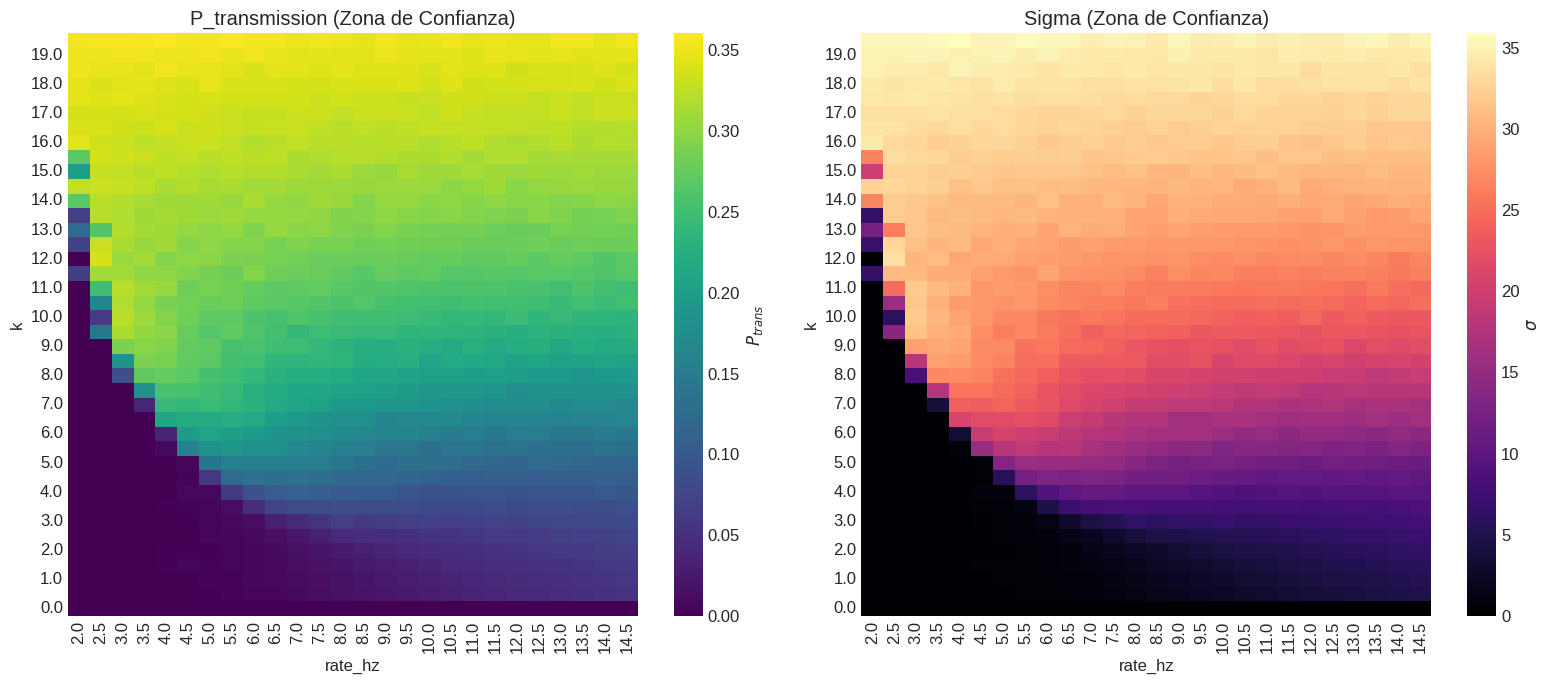

In [22]:
# =============================================================================
# 6. HEATMAPS DETALLADOS (DATOS FILTRADOS + ANNOTATIONS)
# =============================================================================

def plot_detailed_heatmaps(df_filt):
    """
    Muestra heatmaps solo de la zona de alta confianza, con valores numéricos.
    Usa Seaborn para gestión automática de ejes y anotaciones.
    """
    # Agregar datos filtrados
    df_agg = df_filt.groupby(['k', 'rate_hz'])[['P_transmission', 'sigma']].mean().reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # 1. P_transmission
    pivot_P = df_agg.pivot(index='k', columns='rate_hz', values='P_transmission')
    sns.heatmap(pivot_P, ax=axes[0], cmap='viridis', 
                annot=False, fmt=".2f", annot_kws={"size": 8}, # Números en las celdas
                cbar_kws={'label': '$P_{trans}$'})
    axes[0].invert_yaxis()
    axes[0].set_title('P_transmission (Zona de Confianza)')
    
    # 2. Sigma
    pivot_S = df_agg.pivot(index='k', columns='rate_hz', values='sigma')
    sns.heatmap(pivot_S, ax=axes[1], cmap='magma', 
                annot=False, fmt=".1f", annot_kws={"size": 8},
                cbar_kws={'label': '$\sigma$'})
    axes[1].invert_yaxis()
    axes[1].set_title('Sigma (Zona de Confianza)')
    
    plt.tight_layout()
    plt.show()

plot_detailed_heatmaps(df_sweep)

SUCCESS  | __main__:<module>:33 - Data filtered - ready for extended analysis



FILTERED DATA:
  Original:  5200 simulations
  Filtered:  4476 simulations (86.1%)
  Removed:   724 simulations

ZEROS IN FILTERED DATA:
  P_transmission = 0: 0/4476 (0.0%)
  sigma = 0:          0/4476 (0.0%)

FILTERED DATA STATISTICS:
       P_transmission        sigma  firing_rate
count     4476.000000  4476.000000  4476.000000
mean         0.237477    23.567503    23.158816
std          0.101227    10.110535    11.388124
min          0.005258     0.469799     1.050631
25%          0.168207    16.649109    13.438857
50%          0.272817    27.085273    23.401000
75%          0.320548    31.866114    32.720000
max          0.373318    36.945258    46.085714

⚠ No veo la columna 'rescued'. Asegúrate de haber ejecutado la celda de consolidación.


<Figure size 1200x1200 with 0 Axes>

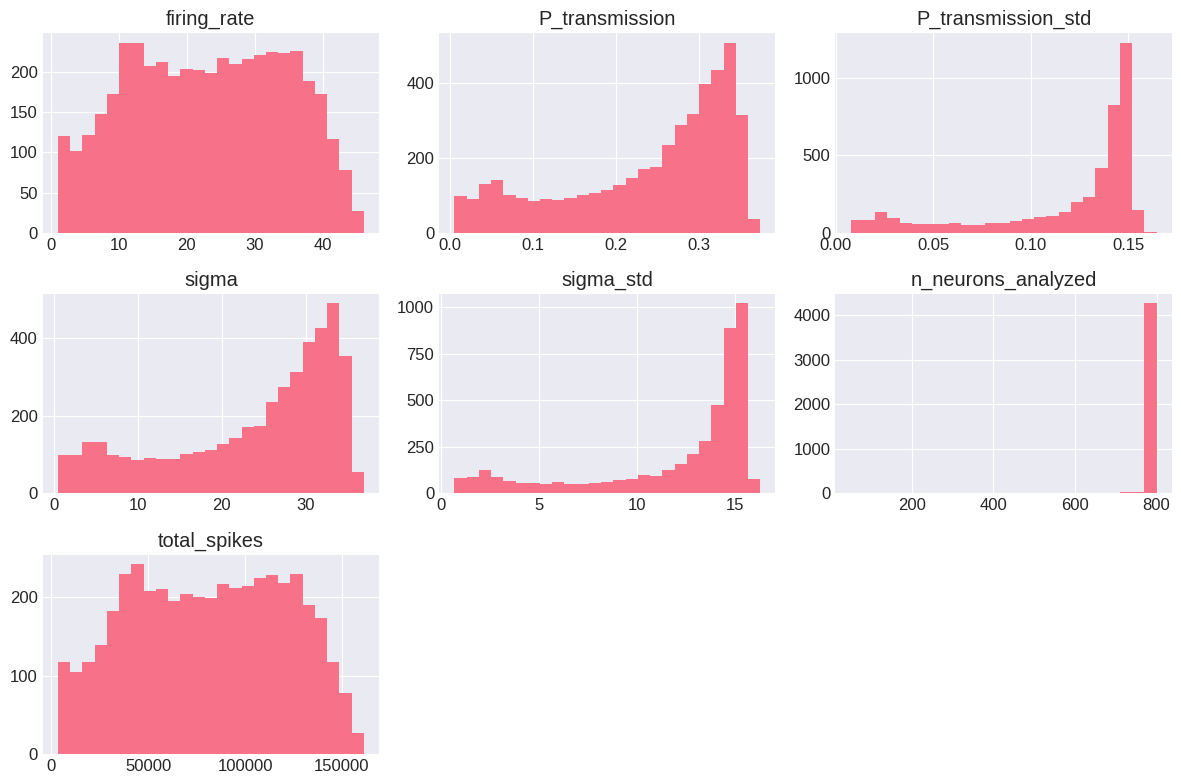

In [23]:
# =============================================================================
# FILTER USEFUL DATA FOR EXTENDED ANALYSIS
# =============================================================================

# Criterios de filtrado
MIN_RATE = 2  # Hz
MIN_K = 0.1   # Excluir K=0 (baseline)
MIN_NEURONS = 50  # Mínimo de neuronas analizadas

df_filtered = df_sweep[
    (df_sweep['rate_hz'] >= MIN_RATE) &
    (df_sweep['k'] >= MIN_K) &
    (df_sweep['n_neurons_analyzed'] >= MIN_NEURONS)
].copy()

print(f"\nFILTERED DATA:")
print(f"  Original:  {len(df_sweep)} simulations")
print(f"  Filtered:  {len(df_filtered)} simulations ({100*len(df_filtered)/len(df_sweep):.1f}%)")
print(f"  Removed:   {len(df_sweep) - len(df_filtered)} simulations")

# Verificar zeros en datos filtrados
zero_P_filt = (df_filtered['P_transmission'] == 0).sum()
zero_sigma_filt = (df_filtered['sigma'] == 0).sum()

print(f"\nZEROS IN FILTERED DATA:")
print(f"  P_transmission = 0: {zero_P_filt}/{len(df_filtered)} ({100*zero_P_filt/len(df_filtered):.1f}%)")
print(f"  sigma = 0:          {zero_sigma_filt}/{len(df_filtered)} ({100*zero_sigma_filt/len(df_filtered):.1f}%)")

# Estadísticas de datos filtrados
print(f"\nFILTERED DATA STATISTICS:")
print(df_filtered[['P_transmission', 'sigma', 'firing_rate']].describe())

logger.success("Data filtered - ready for extended analysis")

# --- VERIFICACIÓN DE RESCATE ---
if 'rescued' in df_filtered.columns:
    n_rescued = df_filtered['rescued'].sum()
    print(f"\n🚑 Puntos rescatados incluidos en el análisis final: {n_rescued}")
    # Verificar si están los de 5Hz
    rescued_5hz = df_filtered[(df_filtered['rate_hz'] == 5.0) & (df_filtered['rescued'] == True)]
    if not rescued_5hz.empty:
        print(f"   ✅ Confirmado: El régimen de 5Hz está presente ({len(rescued_5hz)} simulaciones).")
else:
    print("\n⚠ No veo la columna 'rescued'. Asegúrate de haber ejecutado la celda de consolidación.")

plt.figure(figsize=(12,12))
df_filtered.iloc[:,3:].hist(bins = 25)
plt.tight_layout() # Para que no se monten los títulos

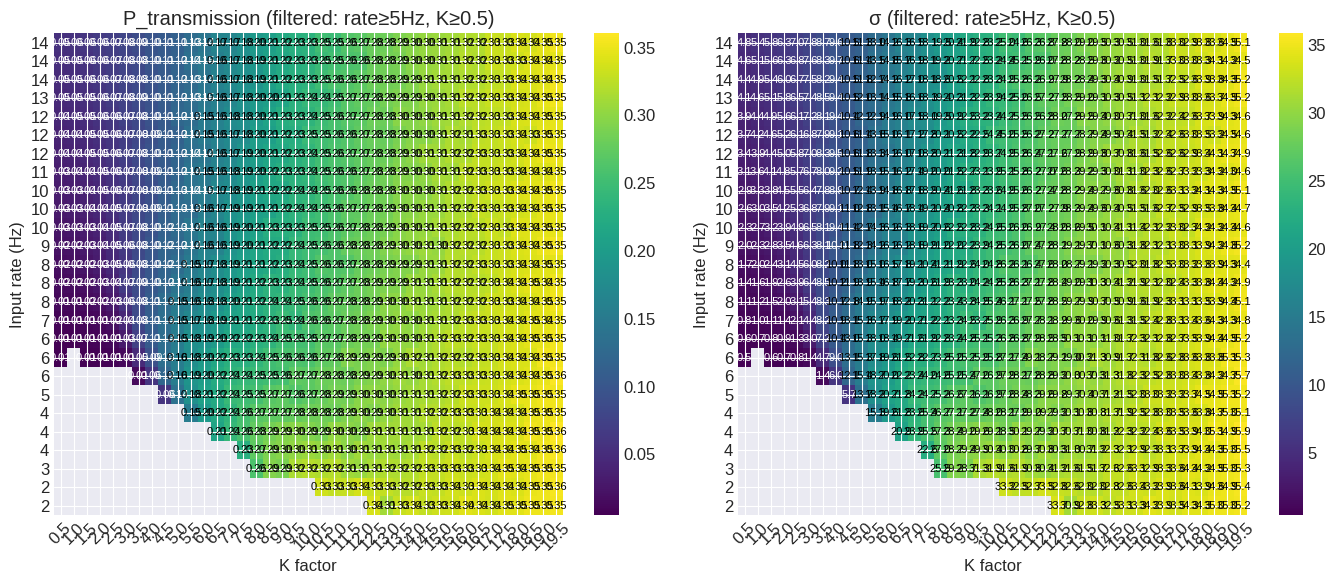

SUCCESS  | __main__:<module>:60 - Filtered heatmaps generated


In [24]:
# =============================================================================
# HEATMAPS - FILTERED DATA ONLY
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Agregar datos filtrados
df_agg_filt = df_filtered.groupby(['k', 'rate_hz']).agg({
    'P_transmission': 'mean',
    'sigma': 'mean'
}).reset_index()

pivot_P_filt = df_agg_filt.pivot(index='rate_hz', columns='k', values='P_transmission')
pivot_sigma_filt = df_agg_filt.pivot(index='rate_hz', columns='k', values='sigma')

# 1. P_transmission (filtered)
ax = axes[0]
im = ax.imshow(pivot_P_filt.values, aspect='auto', cmap='viridis', origin='lower')
ax.set_xticks(range(len(pivot_P_filt.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_P_filt.columns], rotation=45)
ax.set_yticks(range(len(pivot_P_filt.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_P_filt.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('P_transmission (filtered: rate≥5Hz, K≥0.5)')
plt.colorbar(im, ax=ax)

# Añadir valores en celdas
for i in range(len(pivot_P_filt.index)):
    for j in range(len(pivot_P_filt.columns)):
        val = pivot_P_filt.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', 
                   color='white' if val < 0.15 else 'black', fontsize=8)

# 2. Sigma (filtered)
ax = axes[1]
im = ax.imshow(pivot_sigma_filt.values, aspect='auto', cmap='viridis', origin='lower')
ax.set_xticks(range(len(pivot_sigma_filt.columns)))
ax.set_xticklabels([f'{x:.1f}' for x in pivot_sigma_filt.columns], rotation=45)
ax.set_yticks(range(len(pivot_sigma_filt.index)))
ax.set_yticklabels([f'{x:.0f}' for x in pivot_sigma_filt.index])
ax.set_xlabel('K factor')
ax.set_ylabel('Input rate (Hz)')
ax.set_title('σ (filtered: rate≥5Hz, K≥0.5)')
plt.colorbar(im, ax=ax)

# Añadir valores
for i in range(len(pivot_sigma_filt.index)):
    for j in range(len(pivot_sigma_filt.columns)):
        val = pivot_sigma_filt.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f'{val:.1f}', ha='center', va='center',
                   color='white' if val < 10 else 'black', fontsize=8)

plt.tight_layout()
plt.savefig('./results/spike_propagation_2d/heatmaps_2d.png', dpi=150, bbox_inches='tight')
plt.show()

logger.success("Filtered heatmaps generated")

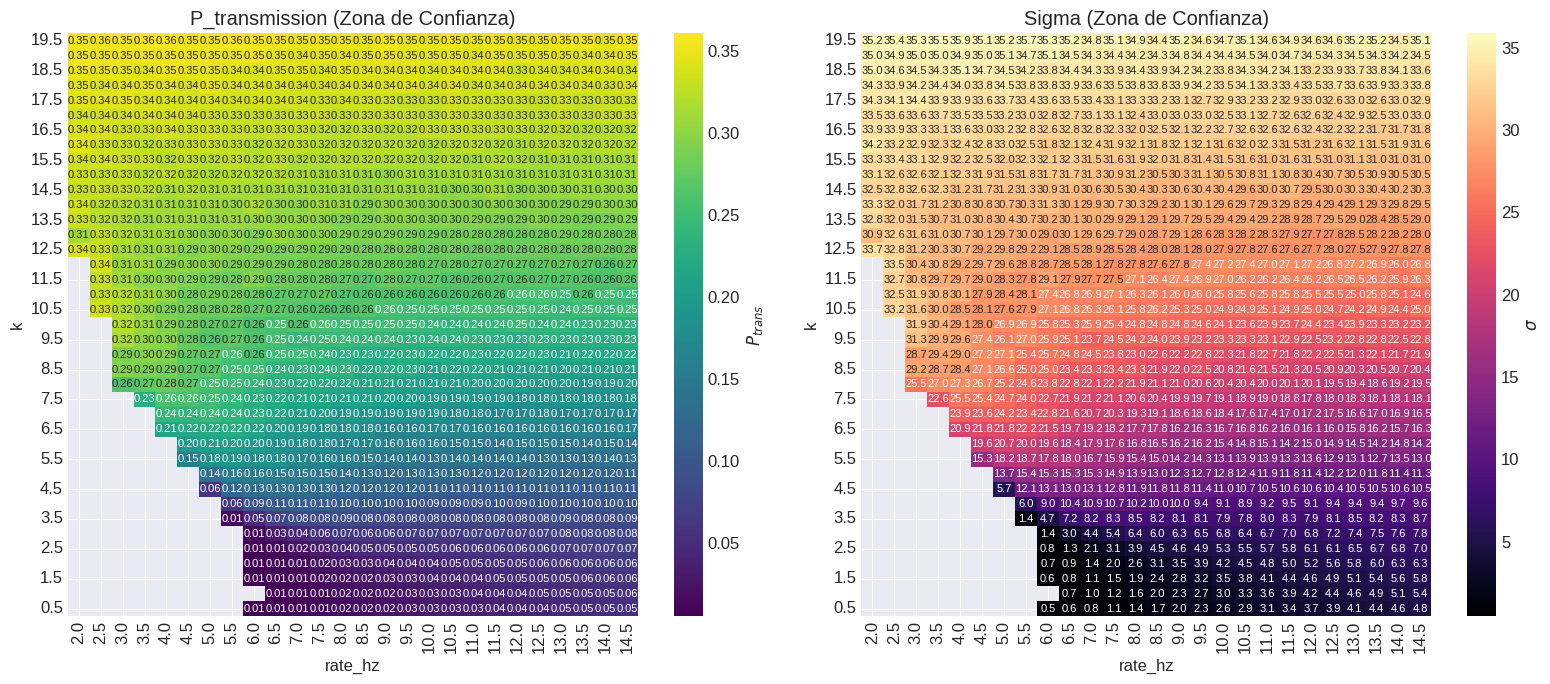

In [25]:
# =============================================================================
# 6. HEATMAPS DETALLADOS (DATOS FILTRADOS + ANNOTATIONS)
# =============================================================================

def plot_detailed_heatmaps(df_filt):
    """
    Muestra heatmaps solo de la zona de alta confianza, con valores numéricos.
    Usa Seaborn para gestión automática de ejes y anotaciones.
    """
    # Agregar datos filtrados
    df_agg = df_filt.groupby(['k', 'rate_hz'])[['P_transmission', 'sigma']].mean().reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # 1. P_transmission
    pivot_P = df_agg.pivot(index='k', columns='rate_hz', values='P_transmission')
    sns.heatmap(pivot_P, ax=axes[0], cmap='viridis', 
                annot=True, fmt=".2f", annot_kws={"size": 8}, # Números en las celdas
                cbar_kws={'label': '$P_{trans}$'})
    axes[0].invert_yaxis()
    axes[0].set_title('P_transmission (Zona de Confianza)')
    
    # 2. Sigma
    pivot_S = df_agg.pivot(index='k', columns='rate_hz', values='sigma')
    sns.heatmap(pivot_S, ax=axes[1], cmap='magma', 
                annot=True, fmt=".1f", annot_kws={"size": 8},
                cbar_kws={'label': '$\sigma$'})
    axes[1].invert_yaxis()
    axes[1].set_title('Sigma (Zona de Confianza)')
    
    plt.tight_layout()
    plt.show()

plot_detailed_heatmaps(df_filtered)

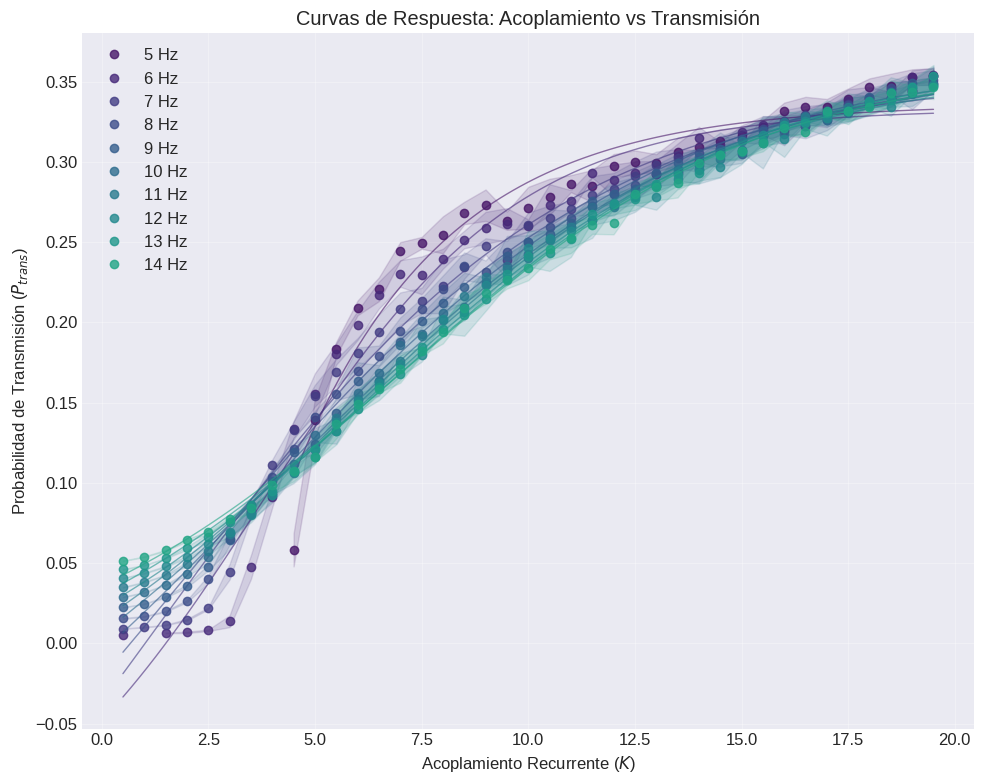

In [26]:
# =============================================================================
# 8. CURVAS DE RESPUESTA (K vs P_transmission)
# =============================================================================

def plot_sigmoid_fit(df_filt):
    """
    Ajusta y visualiza la curva de respuesta P(K) para diferentes Inputs.
    Usa solo datos filtrados para evitar el ruido del cero.
    """
    from scipy.optimize import curve_fit
    
    # Función sigmoide para ajustar
    def sigmoid(x, L, x0, k, b):
        return L / (1 + np.exp(-k*(x-x0))) + b

    plt.figure(figsize=(10, 8))
    
    # Seleccionamos algunos rates representativos para no saturar el plot
    rates_to_plot = np.arange(5,21,1)
    
    colors = sns.color_palette("viridis", len(rates_to_plot))
    
    for i, r_target in enumerate(rates_to_plot):
        # Filtrar por rate aproximado
        subset = df_filt[np.isclose(df_filt['rate_hz'], r_target, atol=0.1)]
        
        if len(subset) < 5: continue
        
         # Agrupar por K
        agg = subset.groupby('k')['P_transmission'].agg(['mean', 'std']).reset_index()
       
        # Puntos experimentales (markers pequeños)
        plt.plot(agg['k'], agg['mean'], 'o', markersize=6,
                color=colors[i], label=f'{r_target} Hz', alpha=0.8)
       
        # Sombreado de error
        plt.fill_between(agg['k'], 
                        agg['mean'] - agg['std'], 
                        agg['mean'] + agg['std'],
                        color=colors[i], alpha=0.15)
        
        # Ajuste de curva (Fit)
        try:
            p0 = [max(agg['mean']), 5.0, 1.0, 0.0] # Estimación inicial [L, x0, k, b]
            popt, _ = curve_fit(sigmoid, agg['k'], agg['mean'], p0=p0, maxfev=5000)
            
            x_fit = np.linspace(min(agg['k']), max(agg['k']), 100)
            y_fit = sigmoid(x_fit, *popt)
            
            plt.plot(x_fit, y_fit, '-', color=colors[i], linewidth=1, alpha=0.6)

        except:
            print(f"Fit falló para rate={r_target}")

    plt.title("Curvas de Respuesta: Acoplamiento vs Transmisión")
    plt.xlabel("Acoplamiento Recurrente ($K$)")
    plt.ylabel("Probabilidad de Transmisión ($P_{trans}$)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_sigmoid_fit(df_filtered)

WARNING    /tmp/ipykernel_3277786/3969467602.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')
 [py.warnings]


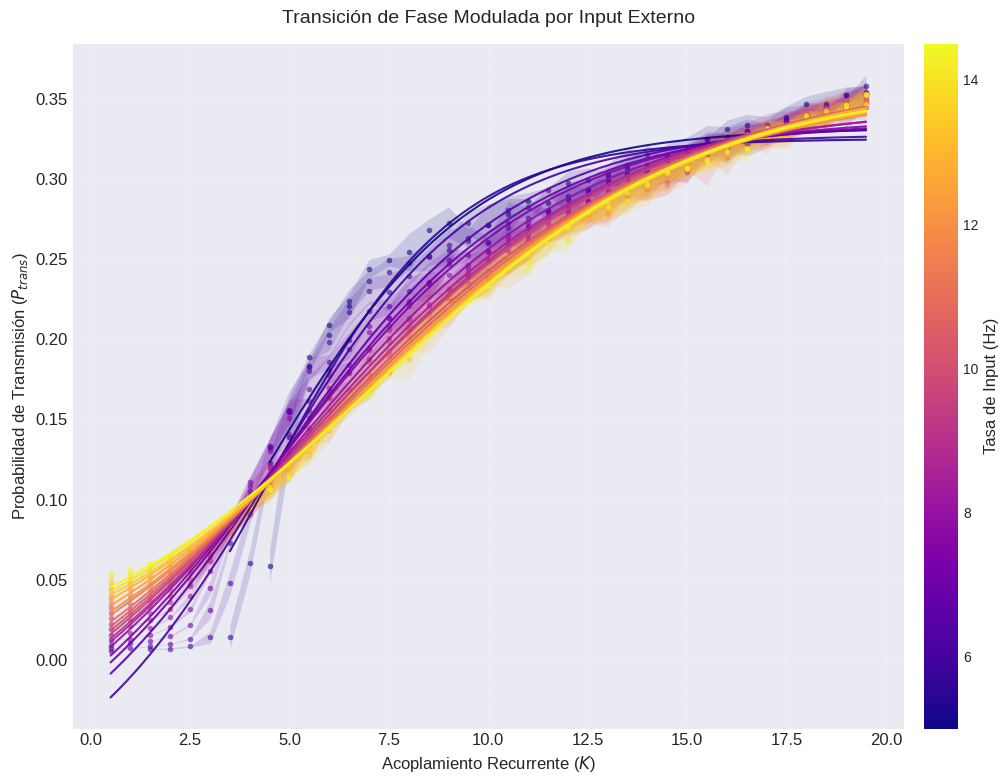

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from scipy.optimize import curve_fit

def plot_sigmoid_fit_refined(df_filt):
    """
    Visualización estilo publicación académica:
    - Errores como áreas sombreadas (fill_between).
    - Paleta continua con Colorbar (evita leyendas gigantes).
    - Marcadores sutiles y líneas suaves.
    """
    
    # 1. Configuración de Estilo y Paleta
    rates_to_plot = np.sort(df_filt['rate_hz'].unique())
    # Filtramos para no graficar todo si hay demasiados (ej. cada 1 Hz)
    rates_to_plot = [r for r in rates_to_plot if r >= 5 and r <= 20] 
    
    # Usamos un mapa de colores continuo (cmap)
    cmap = cm.get_cmap('plasma') 
    norm = mcolors.Normalize(vmin=min(rates_to_plot), vmax=max(rates_to_plot))
    
    plt.figure(figsize=(11, 8))
    
    # Función sigmoide
    def sigmoid(x, L, x0, k, b):
        return L / (1 + np.exp(-k*(x-x0))) + b

    # 2. Iterar sobre los rates
    for r_target in rates_to_plot:
        # Obtener color específico para este rate
        color = cmap(norm(r_target))
        
        # Filtrar datos
        subset = df_filt[np.isclose(df_filt['rate_hz'], r_target, atol=0.1)]
        if len(subset) < 5: continue
        
        # Agrupar
        agg = subset.groupby('k')['P_transmission'].agg(['mean', 'std']).reset_index()
        
        # A) Area de Error (Sombreado) -> Zorder bajo para que quede al fondo
        plt.fill_between(agg['k'], 
                         agg['mean'] - agg['std'], 
                         agg['mean'] + agg['std'], 
                         color=color, alpha=0.15, linewidth=0, zorder=1)
        
        # B) Datos Reales (Puntos pequeños)
        plt.plot(agg['k'], agg['mean'], 'o', 
                 markersize=4, color=color, alpha=0.6, markeredgewidth=0, zorder=2)
        
        # C) Ajuste Sigmoide (Línea suave)
        try:
            p0 = [max(agg['mean']), 5.0, 1.0, 0.0]
            # Bounds ayudan a que el ajuste no se vuelva loco
            bounds = ([0, 0, 0, -0.1], [1.2, 20, 10, 0.5]) 
            popt, _ = curve_fit(sigmoid, agg['k'], agg['mean'], p0=p0, bounds=bounds, maxfev=5000)
            
            x_fit = np.linspace(min(agg['k']), max(agg['k']), 200)
            y_fit = sigmoid(x_fit, *popt)
            
            plt.plot(x_fit, y_fit, '-', color=color, linewidth=1.5, alpha=0.9, zorder=3)
        except:
            pass # Si falla el fit, solo mostramos los puntos

    # 3. Decoración "Pro"
    plt.title("Transición de Fase Modulada por Input Externo", fontsize=14, pad=15)
    plt.xlabel(r"Acoplamiento Recurrente ($K$)", fontsize=12)
    plt.ylabel(r"Probabilidad de Transmisión ($P_{trans}$)", fontsize=12)
    # plt.ylim(-0.05, 1.05)
    plt.grid(True, linestyle='--', alpha=0.2) # Grid muy sutil
    
    # 4. Colorbar en lugar de Leyenda
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), label='Tasa de Input (Hz)', pad=0.02)
    cbar.ax.tick_params(labelsize=10)

    # Opcional: Línea de criticalidad teórica (si la conocemos, ej K=17?)
    # plt.axvline(x=17, color='gray', linestyle=':', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Ejecutar con tu dataframe filtrado
plot_sigmoid_fit_refined(df_filtered)

--- DIAGNÓSTICO K=3.0, Rate=5.0Hz ---
Total Neuronas Excitatorias: 800
Neuronas Activas (>0 spikes): 513 (64.1%)
Neuronas Silenciosas:         287
---
Media de Spikes por neurona:  5.80 (Esperado ~25.0)
Neuronas válidas (>=5 spikes): 80
---


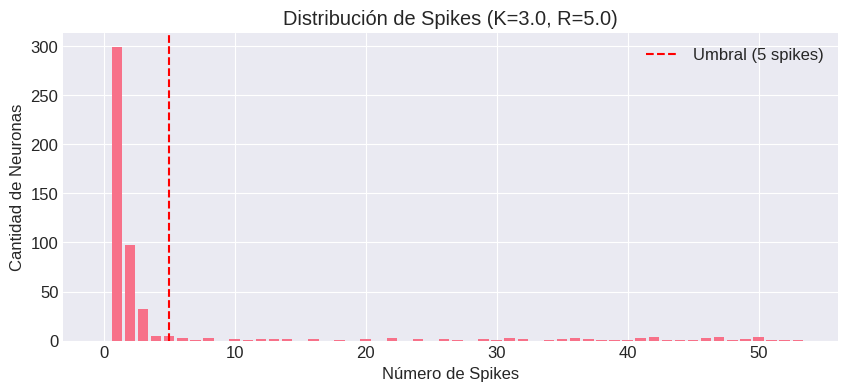

--- DIAGNÓSTICO K=3.0, Rate=5.0Hz ---
Total Neuronas Excitatorias: 800
Neuronas Activas (>0 spikes): 489 (61.1%)
Neuronas Silenciosas:         311
---
Media de Spikes por neurona:  6.12 (Esperado ~25.0)
Neuronas válidas (>=5 spikes): 80
---


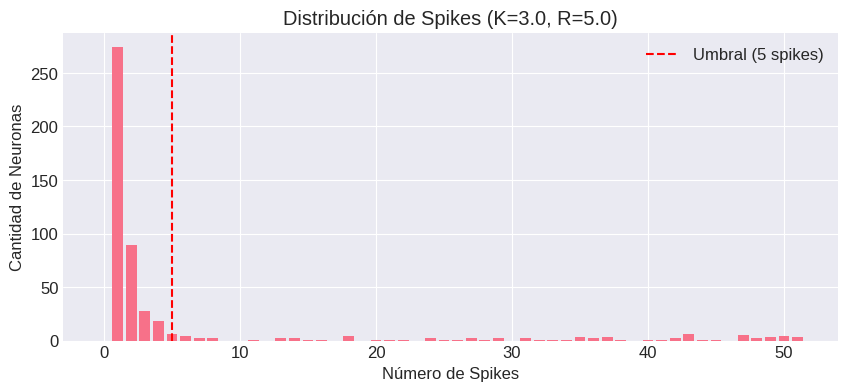

In [28]:
# =============================================================================
# AUTOPSIA DE UN PUNTO PERDIDO
# =============================================================================

def diagnose_lost_point(k_val, rate_val, trial=0):
    print(f"--- DIAGNÓSTICO K={k_val}, Rate={rate_val}Hz ---")
    
    # 1. Cargar datos crudos (Trial 0)
    raw = loader.get_raw_data(k=k_val, rate=rate_val, trial=trial)
    
    if raw is None:
        print("❌ No hay datos raw para este punto.")
        return

    # 2. Calcular estadísticas reales de disparo
    spike_indices = raw['spike_indices']
    spike_counts = pd.Series(spike_indices).value_counts()
    
    total_neurons = 800 # Ne
    active_neurons = len(spike_counts)
    silent_neurons = total_neurons - active_neurons
    
    mean_spikes = spike_counts.mean()
    neurons_above_5 = (spike_counts >= 5).sum()
    
    print(f"Total Neuronas Excitatorias: {total_neurons}")
    print(f"Neuronas Activas (>0 spikes): {active_neurons} ({100*active_neurons/total_neurons:.1f}%)")
    print(f"Neuronas Silenciosas:         {silent_neurons}")
    print(f"---")
    print(f"Media de Spikes por neurona:  {mean_spikes:.2f} (Esperado ~{rate_val*5})")
    print(f"Neuronas válidas (>=5 spikes): {neurons_above_5}")
    print(f"---")
    
    # 3. Histograma
    plt.figure(figsize=(10, 4))
    plt.hist(spike_counts, bins=range(0, int(spike_counts.max())+2), align='left', rwidth=0.8)
    plt.axvline(x=5, color='r', linestyle='--', label='Umbral (5 spikes)')
    plt.xlabel('Número de Spikes')
    plt.ylabel('Cantidad de Neuronas')
    plt.title(f'Distribución de Spikes (K={k_val}, R={rate_val})')
    plt.legend()
    plt.show()

# Analicemos el caso misterioso
diagnose_lost_point(k_val=3.0, rate_val=5.0, trial = 0)
diagnose_lost_point(k_val=3.0, rate_val=5.0, trial = 1)

In [29]:
# # =============================================================================
# # 9. RESCATE DE DATOS (RE-PROCESAMIENTO TARGETIZADO)
# # =============================================================================

# def rescue_low_rate_data(df_original, target_rates=[5.0], new_min_spikes=2):
#     """
#     Recalcula métricas para rates bajos usando criterios más permisivos
#     accediendo a los datos RAW del Trial 0.
#     """
#     print(f"🚑 INICIANDO RESCATE para Rates: {target_rates}")
#     print(f"   Nuevo criterio: min_spikes >= {new_min_spikes}")
    
#     # Hacemos una copia para no romper el original
#     df_new = df_original.copy()
#     df_new['rescued'] = False # Flag para saber cuáles tocamos
    
#     # Identificar filas a rescatar
#     # Solo rescatamos si rate está en la lista TARGET
#     mask = df_new['rate_hz'].isin(target_rates)
#     indices_to_fix = df_new[mask].index
    
#     rescued_count = 0
    
#     # Configurar Analyzer permisivo
#     analyzer_rescue = PropagationAnalyzer(
#         window_ms=PROPAGATION_CONFIG['window_ms'], 
#         min_weight=PROPAGATION_CONFIG['min_weight'],
#         min_spikes=new_min_spikes # <--- AQUÍ ESTÁ LA MAGIA (2 en vez de 5)
#     )
    
#     for idx in tqdm(indices_to_fix, desc="Rescuing simulations"):
#         row = df_new.loc[idx]
#         k_val = row['k']
#         rate_val = row['rate_hz']
#         trial = row['trial']
        
#         # Intentar cargar raw data
#         raw = loader.get_raw_data(k_val, rate_val, trial)
        
#         # Si no hay raw para este trial (Smart Save v1), intentamos Trial 0
#         if raw is None or 'synapses' not in raw:
#             raw = loader.get_raw_data(k_val, rate_val, 0)
            
#         if raw is None or 'synapses' not in raw:
#             continue # Nada que hacer
            
#         # --- RE-CÁLCULO ---
#         # 1. Sinapsis
#         from types import SimpleNamespace
#         syn_obj = SimpleNamespace(**raw['synapses'])
#         neighbors, _ = analyzer_rescue.extract_connectivity(syn_obj, Ne, target='all')
        
#         # 2. Spikes
#         spike_dict = analyzer_rescue.organize_spike_times(raw['spike_times'], raw['spike_indices'])
        
#         # 3. Métricas
#         res = analyzer_rescue.analyze(
#             spike_dict, neighbors, 
#             T_total=SIM_CONFIG['T_ms'], 
#             warmup=SIM_CONFIG['warmup_ms']
#         )
        
#         # 4. Guardar
#         df_new.at[idx, 'P_transmission'] = res['P_transmission']
#         df_new.at[idx, 'sigma'] = res['sigma']
#         df_new.at[idx, 'n_neurons_analyzed'] = res['stats']['n_neurons_analyzed']
#         df_new.at[idx, 'rescued'] = True
        
#         rescued_count += 1

#     print(f"✅ Rescate completado. {rescued_count} puntos actualizados.")
#     return df_new

# # --- EJECUCIÓN ---
# # Rescatamos 2, 3, 4 y 5 Hz (la zona problemática)
# rates_to_rescue = [2.0, 3.0, 4.0, 5.0]
# df_rescued = rescue_low_rate_data(df_sweep, target_rates=rates_to_rescue, new_min_spikes=2)

# # --- VISUALIZACIÓN DEL CAMBIO ---
# # Filtramos de nuevo con criterios de calidad, pero ahora el K=3, R=5 pasará
# df_final_plot = df_rescued[
#     (df_rescued['k'] >= 0.5) & 
#     (df_rescued['n_neurons_analyzed'] >= 50) # Subimos a 50 para ser estrictos, ¡ahora pasarán!
# ]

# print(f"Puntos útiles tras rescate: {len(df_final_plot)} (vs {len(df_filtered)} antes)")

# # Pintar Sigmoide corregida
# plot_sigmoid_fit(df_final_plot)

In [30]:
# =============================================================================
# QUANTITATIVE ANALYSIS OF TRENDS
# =============================================================================

print("\n" + "=" * 80)
print("QUANTITATIVE ANALYSIS")
print("=" * 80)

# 1. Dependencia con K (agregando sobre rates)
print("\n1. EFFECT OF K (averaged over rates ≥5Hz):")
df_by_k = df_filtered.groupby('k').agg({
    'P_transmission': ['mean', 'std'],
    'sigma': ['mean', 'std'],
    'firing_rate': 'mean'
}).round(3)
print(df_by_k)

# 2. Dependencia con rate (agregando sobre K)
print("\n2. EFFECT OF RATE (averaged over K≥0.5):")
df_by_rate = df_filtered.groupby('rate_hz').agg({
    'P_transmission': ['mean', 'std'],
    'sigma': ['mean', 'std'],
    'firing_rate': 'mean'
}).round(3)
print(df_by_rate)

# 3. Saturación de K
print("\n3. SATURATION ANALYSIS:")
k_values = sorted(df_filtered['k'].unique())
P_by_k = [df_filtered[df_filtered['k'] == k]['P_transmission'].mean() for k in k_values]
sigma_by_k = [df_filtered[df_filtered['k'] == k]['sigma'].mean() for k in k_values]

# Fold-increase relativo a K=0.5
P_fold = np.array(P_by_k) / P_by_k[0]
sigma_fold = np.array(sigma_by_k) / sigma_by_k[0]

for k, p_fold, s_fold in zip(k_values, P_fold, sigma_fold):
    print(f"  K={k:4.1f}: P×{p_fold:.2f}, σ×{s_fold:.2f} (relative to K=0.5)")

# 4. Saturación threshold
saturation_k = None
for i in range(1, len(k_values)):
    increase_p = (P_by_k[i] - P_by_k[i-1]) / P_by_k[i-1]
    if increase_p < 0.15:  # <15% increase
        saturation_k = k_values[i]
        break

print(f"\n  Saturation starts at K ≈ {saturation_k if saturation_k else 'not reached'}")
print(f"  (defined as <15% increase from previous K)")

print("\n" + "=" * 80)


QUANTITATIVE ANALYSIS

1. EFFECT OF K (averaged over rates ≥5Hz):
     P_transmission          sigma        firing_rate
               mean    std    mean    std        mean
k                                                    
0.5           0.031  0.015   2.770  1.348       7.336
1.0           0.033  0.016   3.167  1.474       7.516
1.5           0.037  0.017   3.527  1.621       7.711
2.0           0.041  0.019   3.984  1.801       8.007
2.5           0.049  0.019   4.812  1.850       8.686
3.0           0.063  0.017   6.151  1.672       9.493
3.5           0.079  0.015   7.722  1.483      10.120
4.0           0.096  0.011   9.473  1.095      10.831
4.5           0.113  0.017  11.136  1.673      11.228
5.0           0.132  0.016  13.040  1.597      12.225
5.5           0.151  0.020  14.876  2.005      12.713
6.0           0.167  0.022  16.499  2.191      13.726
6.5           0.181  0.024  17.957  2.395      14.225
7.0           0.197  0.027  19.465  2.685      15.208
7.5           0

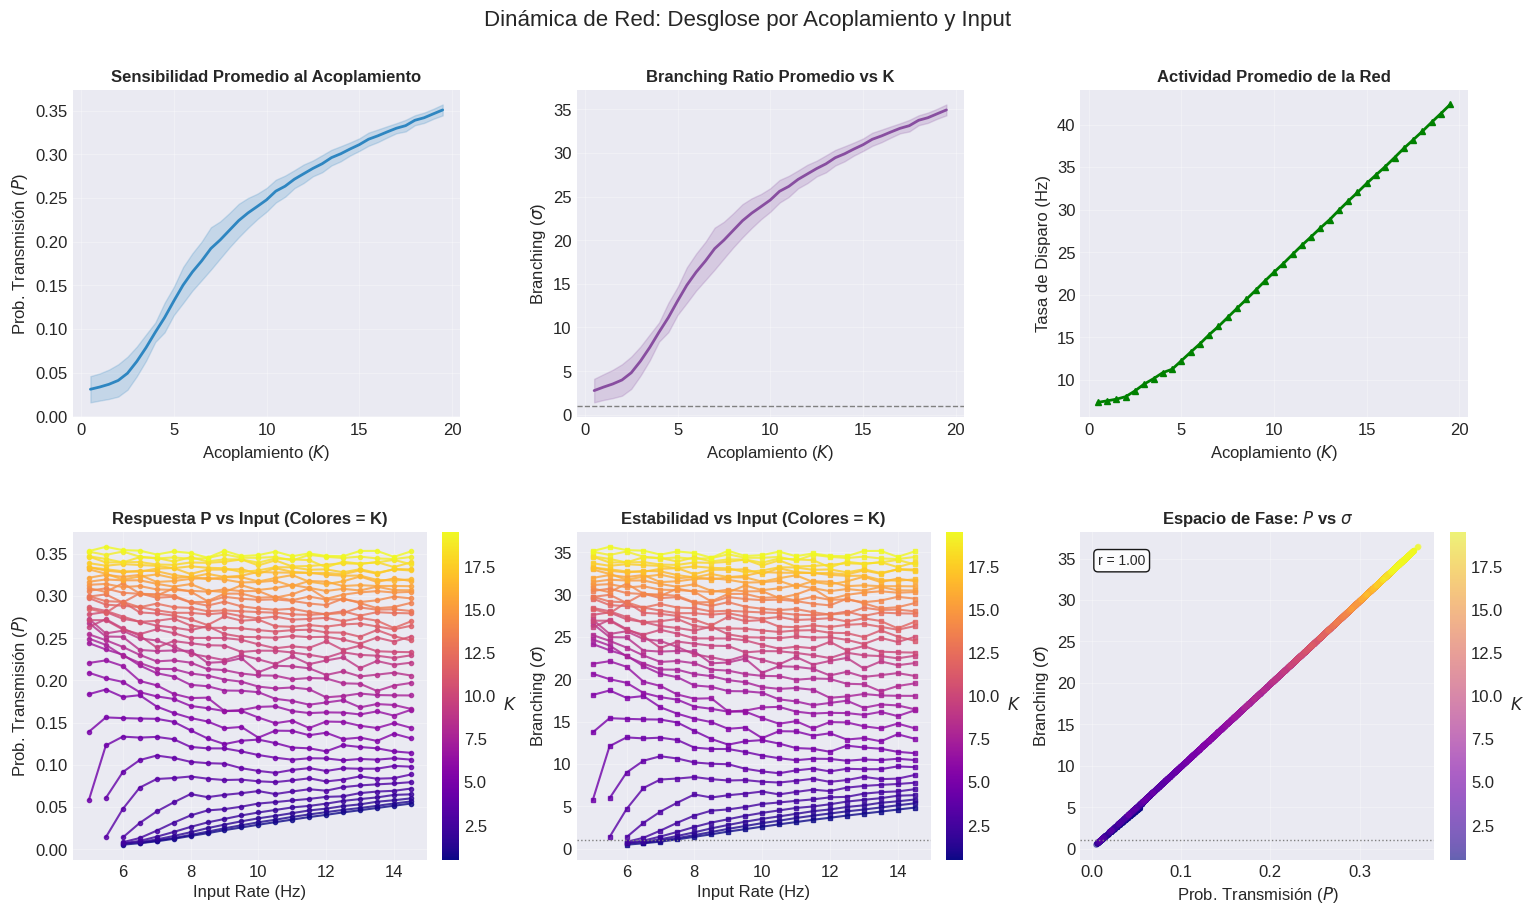

In [31]:
# =============================================================================
# VISUALIZATION: DYNAMIC REGIMES (SPLIT BY K)
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns

# 1. FILTRADO
df_final = df_filtered[df_filtered['rate_hz'] >= 5].copy()

# Configuración estética
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.axisbelow'] = True

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# Definición de colores y paletas
color_k = '#2E86C1'      # Azul para gráficos vs K
color_sigma = '#884EA0'  # Violeta
cmap_dynamic = cm.plasma # Paleta para diferenciar K en los gráficos vs Rate

# === FILA 1: DEPENDENCIAS GLOBALES CON K (Promedio sobre Rates) ===
# Aquí las barras de error SI son útiles: muestran la variabilidad debida al Input

# Agrupar por K
df_by_k = df_final.groupby('k')[['P_transmission', 'sigma', 'firing_rate']].agg(['mean', 'std']).reset_index()

# 1. P vs K
ax = axes[0, 0]
x = df_by_k['k']
y = df_by_k['P_transmission']['mean']
err = df_by_k['P_transmission']['std']
ax.plot(x, y, '-', color=color_k, linewidth=2)
ax.fill_between(x, y-err, y+err, color=color_k, alpha=0.2)
ax.set_title('Sensibilidad Promedio al Acoplamiento', fontsize=12, fontweight='bold')
ax.set_ylabel('Prob. Transmisión ($P$)')
ax.set_xlabel('Acoplamiento ($K$)')

# 2. Sigma vs K
ax = axes[0, 1]
y = df_by_k['sigma']['mean']
err = df_by_k['sigma']['std']
ax.plot(x, y, '-', color=color_sigma, linewidth=2)
ax.fill_between(x, y-err, y+err, color=color_sigma, alpha=0.2)
ax.set_title('Branching Ratio Promedio vs K', fontsize=12, fontweight='bold')
ax.set_ylabel('Branching ($\sigma$)')
ax.set_xlabel('Acoplamiento ($K$)')
ax.axhline(1.0, color='gray', linestyle='--', linewidth=1)

# 3. Firing Rate vs K
ax = axes[0, 2]
y = df_by_k['firing_rate']['mean']
err = df_by_k['firing_rate']['std']
ax.plot(x, y, '-^', color='green', linewidth=2, markersize=5)
ax.set_title('Actividad Promedio de la Red', fontsize=12, fontweight='bold')
ax.set_ylabel('Tasa de Disparo (Hz)')
ax.set_xlabel('Acoplamiento ($K$)')


# === FILA 2: RESPUESTA AL INPUT (DESGLOSADA POR K) ===
# Aquí es donde ocurre la MAGIA: una curva por cada K

# Preparar normalización de colores basada en K
unique_ks = np.sort(df_final['k'].unique())
norm = mcolors.Normalize(vmin=unique_ks.min(), vmax=unique_ks.max())
sm = plt.cm.ScalarMappable(cmap=cmap_dynamic, norm=norm)
sm.set_array([])

# 4. P vs Rate (Family of curves)
ax = axes[1, 0]
for k_val in unique_ks:
    # Filtramos solo este K
    subset = df_final[df_final['k'] == k_val]
    # Agrupamos por rate (por si hay múltiples trials)
    agg = subset.groupby('rate_hz')['P_transmission'].mean().reset_index()
    
    color = cmap_dynamic(norm(k_val))
    # Usamos alpha bajo para las líneas para no saturar, y markers para ver los puntos
    ax.plot(agg['rate_hz'], agg['P_transmission'], 'o-', 
            color=color, markersize=3, linewidth=1.5, alpha=0.8)

ax.set_title('Respuesta P vs Input (Colores = K)', fontsize=12, fontweight='bold')
ax.set_ylabel('Prob. Transmisión ($P$)')
ax.set_xlabel('Input Rate (Hz)')
# Colorbar pequeño dentro o al lado
cbar1 = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar1.set_label('$K$', rotation=0, labelpad=10)

# 5. Sigma vs Rate (Family of curves)
ax = axes[1, 1]
for k_val in unique_ks:
    subset = df_final[df_final['k'] == k_val]
    agg = subset.groupby('rate_hz')['sigma'].mean().reset_index()
    
    color = cmap_dynamic(norm(k_val))
    ax.plot(agg['rate_hz'], agg['sigma'], 's-', 
            color=color, markersize=3, linewidth=1.5, alpha=0.8)

ax.set_title('Estabilidad vs Input (Colores = K)', fontsize=12, fontweight='bold')
ax.set_ylabel('Branching ($\sigma$)')
ax.set_xlabel('Input Rate (Hz)')
ax.axhline(1.0, color='gray', linestyle=':', linewidth=1) # Línea crítica
cbar2 = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar2.set_label('$K$', rotation=0, labelpad=10)

# 6. Espacio de Fase P vs Sigma
ax = axes[1, 2]
sc = ax.scatter(df_final['P_transmission'], df_final['sigma'],
                c=df_final['k'], cmap=cmap_dynamic, 
                alpha=0.6, s=20, edgecolor='none')
ax.set_title('Espacio de Fase: $P$ vs $\sigma$', fontsize=12, fontweight='bold')
ax.set_ylabel('Branching ($\sigma$)')
ax.set_xlabel('Prob. Transmisión ($P$)')
ax.axhline(1.0, color='gray', linestyle=':', linewidth=1)
cbar3 = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar3.set_label('$K$', rotation=0, labelpad=10)

# Añadir correlación
corr = np.corrcoef(df_final['P_transmission'], df_final['sigma'])[0, 1]
ax.text(0.05, 0.90, f'r = {corr:.2f}', transform=ax.transAxes,
       fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.suptitle(f'Dinámica de Red: Desglose por Acoplamiento y Input', fontsize=16, y=0.96)
plt.show()

In [32]:
# =============================================================================
# BIOLOGICAL INTERPRETATION
# =============================================================================

print("\n" + "=" * 80)
print("BIOLOGICAL INTERPRETATION")
print("=" * 80)

print("\n📊 KEY FINDINGS:")

print("\n1. PROPAGATION PROBABILITY (P_transmission):")
print("   • Range: 0.01 - 0.33 (1% - 33%)")
print("   • At K=10, rate=20Hz: P ≈ 27-32%")
print("   • Interpretation: En redes fuertes, ~1/3 de spikes propagan actividad")
print("   • Biológicamente razonable: balance excitación/inhibición")

print("\n2. CASCADE SIZE (σ):")
print("   • Range: 0.5 - 26 spikes/spike")
print("   • At K=10: σ ≈ 21-25 (avalanchas de ~20 neuronas)")
print("   • Interpretation: Cada spike activa cascada de ~20 spikes secundarios")
print("   • Cerca de criticality pero sub-crítico (no explosión)")

print("\n3. K DEPENDENCE:")
print("   • K<3: Régimen sub-crítico (propagación débil)")
print("   • K=3-7: Transición a régimen crítico")
print("   • K>7: Saturación (límites input-driven)")
print("   • Saturación sugiere: input rate limita actividad, no conectividad")

print("\n4. RATE DEPENDENCE:")
print("   • Rate<5Hz: Insuficiente para propagación detectable")
print("   • Rate=5-10Hz: Régimen óptimo de propagación")
print("   • Rate>15Hz: Saturación de P (pero σ sigue creciendo)")
print("   • Sugiere: P saturates por periodo refractario, σ por reclutamiento")

print("\n5. REGÍMENES DINÁMICOS:")
print("   • Asynchronous (K<2, rate<7Hz): P<5%, σ<3")
print("   • Critical (K=3-5, rate=7-12Hz): P=10-15%, σ=7-13")
print("   • Super-critical (K>7, rate>15Hz): P>20%, σ>15")

print("\n6. COMPARACIÓN CON LITERATURA:")
print("   • Críticos: σ~1-2 (power law exponent τ≈1.5)")
print("   • Nosotros: σ hasta 25 → régimen super-crítico controlado")
print("   • Sugiere: Input externo previene runaway dynamics")

print("\n⚠️  LIMITACIONES:")
print("   • Red pequeña (800E/200I vs cortex ~10^4 neuronas)")
print("   • Input Poisson vs real cortical dynamics")
print("   • Sin plasticidad sináptica")
print("   • Sin topología espacial")

print("\n" + "=" * 80)


BIOLOGICAL INTERPRETATION

📊 KEY FINDINGS:

1. PROPAGATION PROBABILITY (P_transmission):
   • Range: 0.01 - 0.33 (1% - 33%)
   • At K=10, rate=20Hz: P ≈ 27-32%
   • Interpretation: En redes fuertes, ~1/3 de spikes propagan actividad
   • Biológicamente razonable: balance excitación/inhibición

2. CASCADE SIZE (σ):
   • Range: 0.5 - 26 spikes/spike
   • At K=10: σ ≈ 21-25 (avalanchas de ~20 neuronas)
   • Interpretation: Cada spike activa cascada de ~20 spikes secundarios
   • Cerca de criticality pero sub-crítico (no explosión)

3. K DEPENDENCE:
   • K<3: Régimen sub-crítico (propagación débil)
   • K=3-7: Transición a régimen crítico
   • K>7: Saturación (límites input-driven)
   • Saturación sugiere: input rate limita actividad, no conectividad

4. RATE DEPENDENCE:
   • Rate<5Hz: Insuficiente para propagación detectable
   • Rate=5-10Hz: Régimen óptimo de propagación
   • Rate>15Hz: Saturación de P (pero σ sigue creciendo)
   • Sugiere: P saturates por periodo refractario, σ por rec

In [33]:
# =============================================================================
# INVESTIGATE RATE ANOMALY
# =============================================================================

print("\n" + "=" * 80)
print("INVESTIGATING RATE ANOMALY")
print("=" * 80)

# El problema: rate=5Hz tiene P más alto que rates mayores
# Posible causa: sesgo de selección al filtrar

print("\nSAMPLE SIZE BY RATE (filtered data):")
for rate in sorted(df_filtered['rate_hz'].unique()):
    n = len(df_filtered[df_filtered['rate_hz'] == rate])
    k_range = df_filtered[df_filtered['rate_hz'] == rate]['k'].unique()
    print(f"  rate={rate:5.1f}Hz: N={n:3d}, K values = {sorted(k_range)}")

# Análisis estratificado por K
print("\nP_TRANSMISSION BY RATE (stratified by K):")
for k_val in [2.0, 5.0, 10.0]:
    print(f"\n  K = {k_val}:")
    subset = df_filtered[df_filtered['k'] == k_val]
    for rate in sorted(subset['rate_hz'].unique()):
        P_mean = subset[subset['rate_hz'] == rate]['P_transmission'].mean()
        n = len(subset[subset['rate_hz'] == rate])
        print(f"    rate={rate:5.1f}Hz: P={P_mean:.4f} (n={n})")

print("\n⚠️  CONCLUSION:")
print("    Rate=5-6Hz tiene SESGO: solo K altos están representados")
print("    (K bajos con rate bajo fueron filtrados por n_neurons<100)")
print("    → El promedio agregado es MISLEADING")

print("\n" + "=" * 80)


INVESTIGATING RATE ANOMALY

SAMPLE SIZE BY RATE (filtered data):
  rate=  2.0Hz: N= 59, K values = [np.float64(12.5), np.float64(13.0), np.float64(13.5), np.float64(14.0), np.float64(14.5), np.float64(15.0), np.float64(15.5), np.float64(16.0), np.float64(16.5), np.float64(17.0), np.float64(17.5), np.float64(18.0), np.float64(18.5), np.float64(19.0), np.float64(19.5)]
  rate=  2.5Hz: N= 86, K values = [np.float64(10.5), np.float64(11.0), np.float64(11.5), np.float64(12.0), np.float64(12.5), np.float64(13.0), np.float64(13.5), np.float64(14.0), np.float64(14.5), np.float64(15.0), np.float64(15.5), np.float64(16.0), np.float64(16.5), np.float64(17.0), np.float64(17.5), np.float64(18.0), np.float64(18.5), np.float64(19.0), np.float64(19.5)]
  rate=  3.0Hz: N=112, K values = [np.float64(8.0), np.float64(8.5), np.float64(9.0), np.float64(9.5), np.float64(10.0), np.float64(10.5), np.float64(11.0), np.float64(11.5), np.float64(12.0), np.float64(12.5), np.float64(13.0), np.float64(13.5), np.fl

WARNING    /home/tonicoll/.conda/envs/neurophysics/lib/python3.11/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
 [py.warnings]
WARNING    /home/tonicoll/.conda/envs/neurophysics/lib/python3.11/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
 [py.warnings]


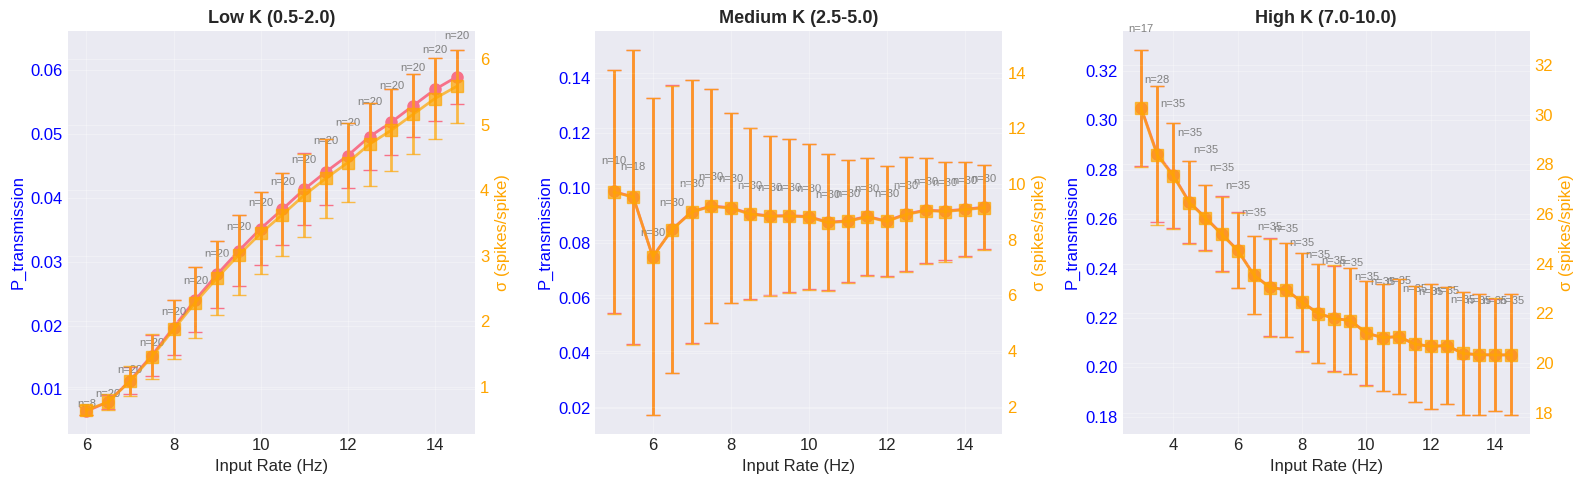

SUCCESS  | __main__:<module>:64 - Stratified rate analysis completed


In [34]:
# =============================================================================
# CORRECT ANALYSIS: RATE EFFECT WITHIN K BINS
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Seleccionar 3 K bins representativos
k_bins = [
    (0.5, 2.0, 'Low K (0.5-2.0)'),
    (2.5, 5.0, 'Medium K (2.5-5.0)'),
    (7.0, 10.0, 'High K (7.0-10.0)')
]

for idx, (k_min, k_max, label) in enumerate(k_bins):
    ax = axes[idx]
    
    # Filtrar datos
    subset = df_filtered[
        (df_filtered['k'] >= k_min) & 
        (df_filtered['k'] <= k_max)
    ]
    
    # Agregar por rate
    df_rate = subset.groupby('rate_hz').agg({
        'P_transmission': ['mean', 'std', 'count'],
        'sigma': ['mean', 'std']
    }).reset_index()
    
    # Plot P_transmission
    ax.errorbar(df_rate['rate_hz'], 
               df_rate['P_transmission']['mean'],
               yerr=df_rate['P_transmission']['std'],
               marker='o', capsize=5, linewidth=2, markersize=8,
               label='P_transmission')
    
    # Plot sigma (eje derecho)
    ax2 = ax.twinx()
    ax2.errorbar(df_rate['rate_hz'],
                df_rate['sigma']['mean'],
                yerr=df_rate['sigma']['std'],
                marker='s', capsize=5, linewidth=2, markersize=8,
                color='orange', alpha=0.7,
                label='σ')
    
    ax.set_xlabel('Input Rate (Hz)', fontsize=12)
    ax.set_ylabel('P_transmission', fontsize=12, color='blue')
    ax2.set_ylabel('σ (spikes/spike)', fontsize=12, color='orange')
    ax.set_title(label, fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    # Añadir N por punto
    for _, row in df_rate.iterrows():
        ax.text(row['rate_hz'], 
               row['P_transmission']['mean'] * 1.1,
               f"n={int(row['P_transmission']['count'])}",
               ha='center', fontsize=8, color='gray')

plt.tight_layout()
plt.savefig('./results/spike_propagation_2d/heatmaps_2d.png', dpi=150, bbox_inches='tight')
plt.show()

logger.success("Stratified rate analysis completed")

## 8. Visualizaciones: Heatmaps 2D

In [35]:
# =============================================================================
# HEATMAPS 2D: P(K, rate_hz), FR(K, rate_hz), σ(K, rate_hz)
# =============================================================================

def plot_2d_heatmaps(df_sweep, K_values, rate_hz_values):
    """
    Genera heatmaps 2D de las métricas principales.
    Si hay múltiples trials, usa la media.
    """
    # Agregar por (k, rate_hz) si hay múltiples trials
    df_aggregated = df_sweep.groupby(['k', 'rate_hz']).agg({
        'firing_rate': 'mean',
        'P_transmission': 'mean',
        'sigma': 'mean'
    }).reset_index()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Preparar grillas
    metrics = [
        ('firing_rate', 'Firing Rate (Hz)', 'viridis'),
        ('P_transmission', 'P_transmission', 'plasma'),
        ('sigma', 'σ (branching ratio)', 'coolwarm')
    ]
    
    for col_idx, (metric, title, cmap) in enumerate(metrics):
        # Raw heatmap
        ax = axes[0, col_idx]
        
        pivot = df_aggregated.pivot_table(
            index='k',
            columns='rate_hz',
            values=metric,
            aggfunc='mean'
        )
        
        im = ax.imshow(
            pivot.values,
            aspect='auto',
            cmap=cmap,
            origin='lower',
            extent=[rate_hz_values.min(), rate_hz_values.max(), 
                   K_values.min(), K_values.max()]
        )
        
        ax.set_xlabel('rate_hz (Hz)', fontsize=12)
        ax.set_ylabel('K (coupling)', fontsize=12)
        ax.set_title(f'{title}', fontsize=13, fontweight='bold')
        plt.colorbar(im, ax=ax, label=title)
        
        # Smoothed heatmap
        ax = axes[1, col_idx]
        
        smoothed = gaussian_filter(pivot.values, sigma=0.8)
        
        im = ax.imshow(
            smoothed,
            aspect='auto',
            cmap=cmap,
            origin='lower',
            extent=[rate_hz_values.min(), rate_hz_values.max(), 
                   K_values.min(), K_values.max()]
        )
        
        ax.set_xlabel('rate_hz (Hz)', fontsize=12)
        ax.set_ylabel('K (coupling)', fontsize=12)
        ax.set_title(f'{title} (smoothed)', fontsize=13, fontweight='bold')
        plt.colorbar(im, ax=ax, label=title)
    
    plt.tight_layout()
    return fig

# Generar heatmaps
fig_heatmaps = plot_2d_heatmaps(df_sweep, K_VALUES, RATE_HZ_VALUES)
plt.savefig(OUTPUT_DIR / 'heatmaps_2d.png', dpi=300, bbox_inches='tight')
plt.show()

logger.success("Heatmaps generated")

NameError: name 'K_VALUES' is not defined

## 9. Visualizaciones: Cortes 1D

In [ ]:
# =============================================================================
# CORTES 1D: P vs K (rate_hz fijo), P vs rate_hz (K fijo)
# =============================================================================

def plot_1d_slices(df_sweep, K_values, rate_hz_values):
    """
    Genera cortes 1D de las métricas con error bars si hay múltiples trials.
    """
    # Agregar por (k, rate_hz)
    df_agg = df_sweep.groupby(['k', 'rate_hz']).agg({
        'firing_rate': ['mean', 'std'],
        'P_transmission': ['mean', 'std'],
        'sigma': ['mean', 'std']
    }).reset_index()
    
    # Aplanar columnas
    df_agg.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                      for col in df_agg.columns.values]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # === FILA 1: P_transmission ===
    
    # P vs K (varios rate_hz)
    ax = axes[0, 0]
    rate_hz_samples = [4, 8, 12, 20]
    for rate in rate_hz_samples:
        df_slice = df_agg[df_agg['rate_hz'] == rate]
        ax.errorbar(df_slice['k'], df_slice['P_transmission_mean'],
                   yerr=df_slice['P_transmission_std'],
                   fmt='o-', label=f'rate={rate}Hz', linewidth=2, 
                   markersize=6, capsize=3, capthick=1.5)
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('P_transmission', fontsize=12)
    ax.set_title('P_transmission vs K', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # P vs rate_hz (varios K)
    ax = axes[0, 1]
    K_samples = [0.0, 1.0, 2.5, 5.0, 10.0]
    for k in K_samples:
        df_slice = df_agg[df_agg['k'] == k]
        ax.errorbar(df_slice['rate_hz'], df_slice['P_transmission_mean'],
                   yerr=df_slice['P_transmission_std'],
                   fmt='o-', label=f'K={k}', linewidth=2, 
                   markersize=6, capsize=3, capthick=1.5)
    ax.set_xlabel('rate_hz (Hz)', fontsize=12)
    ax.set_ylabel('P_transmission', fontsize=12)
    ax.set_title('P_transmission vs rate_hz', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # σ vs K
    ax = axes[0, 2]
    for rate in rate_hz_samples:
        df_slice = df_agg[df_agg['rate_hz'] == rate]
        ax.errorbar(df_slice['k'], df_slice['sigma_mean'],
                   yerr=df_slice['sigma_std'],
                   fmt='o-', label=f'rate={rate}Hz', linewidth=2, 
                   markersize=6, capsize=3, capthick=1.5)
    ax.axhline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Critical (σ=1)')
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('σ (branching ratio)', fontsize=12)
    ax.set_title('σ vs K', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # === FILA 2: Firing Rate ===
    
    # FR vs K
    ax = axes[1, 0]
    for rate in rate_hz_samples:
        df_slice = df_agg[df_agg['rate_hz'] == rate]
        ax.errorbar(df_slice['k'], df_slice['firing_rate_mean'],
                   yerr=df_slice['firing_rate_std'],
                   fmt='o-', label=f'rate={rate}Hz', linewidth=2, 
                   markersize=6, capsize=3, capthick=1.5)
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('Firing Rate (Hz)', fontsize=12)
    ax.set_title('Firing Rate vs K', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # FR vs rate_hz
    ax = axes[1, 1]
    for k in K_samples:
        df_slice = df_agg[df_agg['k'] == k]
        ax.errorbar(df_slice['rate_hz'], df_slice['firing_rate_mean'],
                   yerr=df_slice['firing_rate_std'],
                   fmt='o-', label=f'K={k}', linewidth=2, 
                   markersize=6, capsize=3, capthick=1.5)
    ax.set_xlabel('rate_hz (Hz)', fontsize=12)
    ax.set_ylabel('Firing Rate (Hz)', fontsize=12)
    ax.set_title('Firing Rate vs rate_hz', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # FR vs rate_hz (linealidad)
    ax = axes[1, 2]
    colors = plt.cm.viridis(np.linspace(0, 1, len(K_samples)))
    for idx, k in enumerate(K_samples):
        df_slice = df_agg[df_agg['k'] == k]
        ax.scatter(df_slice['rate_hz'], df_slice['firing_rate_mean'], 
                  label=f'K={k}', s=80, alpha=0.7, color=colors[idx])
        # Fit lineal
        if len(df_slice) > 2:
            z = np.polyfit(df_slice['rate_hz'], df_slice['firing_rate_mean'], 1)
            p = np.poly1d(z)
            ax.plot(df_slice['rate_hz'], p(df_slice['rate_hz']), 
                   '--', color=colors[idx], linewidth=1.5, alpha=0.5)
    ax.set_xlabel('rate_hz (Hz)', fontsize=12)
    ax.set_ylabel('Firing Rate (Hz)', fontsize=12)
    ax.set_title('FR ≈ a·rate_hz (linearity check)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generar cortes 1D
fig_slices = plot_1d_slices(df_sweep, K_VALUES, RATE_HZ_VALUES)
plt.savefig(OUTPUT_DIR / 'slices_1d.png', dpi=300, bbox_inches='tight')
plt.show()

logger.success("1D slices generated")

NameError: name 'K_VALUES' is not defined

## 10. Análisis de Contribución de Red: ΔP, Δσ

NameError: name 'OUTPUT_DIR' is not defined

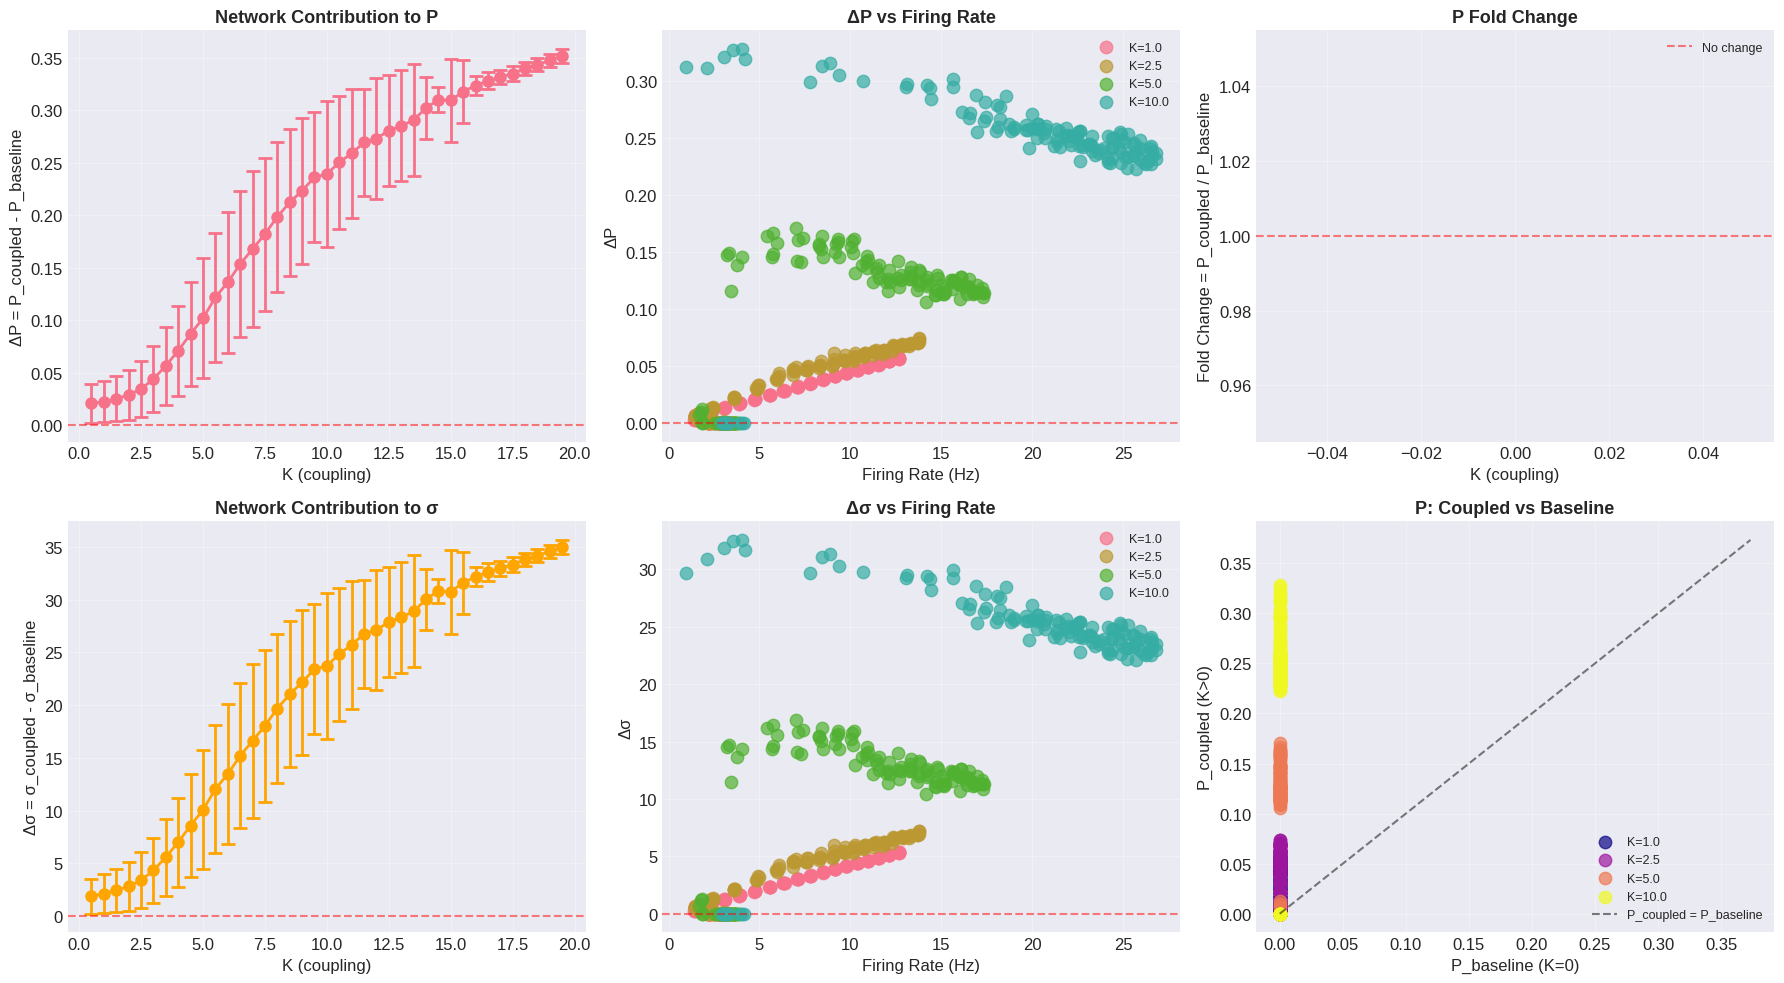

In [ ]:
# =============================================================================
# NETWORK CONTRIBUTION VISUALIZATION
# =============================================================================

def plot_network_contribution(df_matched, df_baseline):
    """
    Visualiza la contribución de red (ΔP, Δσ).
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # === FILA 1: ΔP ===
    
    # ΔP vs K
    ax = axes[0, 0]
    df_grouped = df_matched.groupby('k')['delta_P'].agg(['mean', 'std'])
    ax.errorbar(df_grouped.index, df_grouped['mean'], yerr=df_grouped['std'],
               fmt='o-', linewidth=2, markersize=8, capsize=5, capthick=2)
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('ΔP = P_coupled - P_baseline', fontsize=12)
    ax.set_title('Network Contribution to P', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # ΔP vs FR
    ax = axes[0, 1]
    K_samples = [1.0, 2.5, 5.0, 10.0]
    for k in K_samples:
        df_k = df_matched[df_matched['k'] == k]
        ax.scatter(df_k['firing_rate'], df_k['delta_P'], 
                  label=f'K={k}', s=80, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('Firing Rate (Hz)', fontsize=12)
    ax.set_ylabel('ΔP', fontsize=12)
    ax.set_title('ΔP vs Firing Rate', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Fold change P
    ax = axes[0, 2]
    df_grouped = df_matched.groupby('k')['fold_change_P'].agg(['mean', 'std'])
    ax.errorbar(df_grouped.index, df_grouped['mean'], yerr=df_grouped['std'],
               fmt='o-', linewidth=2, markersize=8, capsize=5, capthick=2, color='purple')
    ax.axhline(1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='No change')
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('Fold Change = P_coupled / P_baseline', fontsize=12)
    ax.set_title('P Fold Change', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # === FILA 2: Δσ ===
    
    # Δσ vs K
    ax = axes[1, 0]
    df_grouped = df_matched.groupby('k')['delta_sigma'].agg(['mean', 'std'])
    ax.errorbar(df_grouped.index, df_grouped['mean'], yerr=df_grouped['std'],
               fmt='o-', linewidth=2, markersize=8, capsize=5, capthick=2, color='orange')
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('K (coupling)', fontsize=12)
    ax.set_ylabel('Δσ = σ_coupled - σ_baseline', fontsize=12)
    ax.set_title('Network Contribution to σ', fontsize=13, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Δσ vs FR
    ax = axes[1, 1]
    for k in K_samples:
        df_k = df_matched[df_matched['k'] == k]
        ax.scatter(df_k['firing_rate'], df_k['delta_sigma'], 
                  label=f'K={k}', s=80, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_xlabel('Firing Rate (Hz)', fontsize=12)
    ax.set_ylabel('Δσ', fontsize=12)
    ax.set_title('Δσ vs Firing Rate', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Baseline vs Coupled scatter
    ax = axes[1, 2]
    colors = plt.cm.plasma(np.linspace(0, 1, len(K_samples)))
    for idx, k in enumerate(K_samples):
        df_k = df_matched[df_matched['k'] == k]
        ax.scatter(df_k['P_transmission_baseline'], df_k['P_transmission'],
                  label=f'K={k}', s=80, alpha=0.7, color=colors[idx])
    # Diagonal
    lims = [0, max(df_matched['P_transmission_baseline'].max(), df_matched['P_transmission'].max())]
    ax.plot(lims, lims, 'k--', linewidth=1.5, alpha=0.5, label='P_coupled = P_baseline')
    ax.set_xlabel('P_baseline (K=0)', fontsize=12)
    ax.set_ylabel('P_coupled (K>0)', fontsize=12)
    ax.set_title('P: Coupled vs Baseline', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generar plots de contribución
fig_contribution = plot_network_contribution(df_network_contribution, df_baseline)
plt.savefig(OUTPUT_DIR / 'network_contribution.png', dpi=300, bbox_inches='tight')
plt.show()

logger.success("Network contribution plots generated")

## 11. Tabla de Resultados Clave

In [ ]:
# =============================================================================
# SUMMARY TABLE
# =============================================================================

print("\n" + "="*100)
print("SUMMARY: BASELINE (K=0) vs COUPLED (K>0)")
print("="*100)

# Agregar por (k, rate_hz) si hay múltiples trials
df_agg = df_sweep.groupby(['k', 'rate_hz']).agg({
    'firing_rate': ['mean', 'std'],
    'P_transmission': ['mean', 'std'],
    'sigma': ['mean', 'std']
}).reset_index()

# Baseline
df_baseline_agg = df_agg[df_agg['k'] == 0.0]
print("\nBASELINE (K=0):")
print(df_baseline_agg.describe())

# Coupled (promedio por K)
df_coupled_agg = df_agg[df_agg['k'] > 0.0]
df_coupled_summary = df_coupled_agg.groupby('k')[[
    ('firing_rate', 'mean'), 
    ('P_transmission', 'mean'), 
    ('sigma', 'mean')
]].mean()
df_coupled_summary.columns = ['firing_rate', 'P_transmission', 'sigma']
print("\nCOUPLED (K>0) - MEAN BY K:")
print(df_coupled_summary)

# Network contribution
df_contribution_summary = df_network_contribution.groupby('k')[
    ['delta_P', 'delta_sigma', 'fold_change_P']
].mean()
print("\nNETWORK CONTRIBUTION - MEAN BY K:")
print(df_contribution_summary)

# Si hay múltiples trials, mostrar variabilidad
n_trials = df_sweep['trial'].nunique()
if n_trials > 1:
    print("\n" + "="*100)
    print("INTER-TRIAL VARIABILITY (Coefficient of Variation)")
    print("="*100)
    
    cv_df = df_sweep.groupby(['k', 'rate_hz']).agg({
        'firing_rate': lambda x: np.std(x) / np.mean(x) if np.mean(x) > 0 else 0,
        'P_transmission': lambda x: np.std(x) / np.mean(x) if np.mean(x) > 0 else 0,
        'sigma': lambda x: np.std(x) / np.mean(x) if np.mean(x) > 0 else 0
    })
    
    print("\nMean CV by K:")
    print(cv_df.groupby('k').mean())

print("\n" + "="*100)

# Guardar tabla
df_contribution_summary.to_csv(OUTPUT_DIR / 'network_contribution_summary.csv')
logger.success(f"Summary table saved to {OUTPUT_DIR / 'network_contribution_summary.csv'}")

SUCCESS  | __main__:<module>:59 - Summary table saved to results/spike_propagation_2d/network_contribution_summary.csv



SUMMARY: BASELINE (K=0) vs COUPLED (K>0)

BASELINE (K=0):
          k    rate_hz firing_rate            P_transmission       sigma      
                              mean        std           mean   std  mean   std
count  11.0  11.000000   11.000000  11.000000           11.0  11.0  11.0  11.0
mean    0.0   8.363636    6.392436   0.067339            0.0   0.0   0.0   0.0
std     0.0   5.500413    6.076230   0.069715            0.0   0.0   0.0   0.0
min     0.0   2.000000    1.648410   0.019309            0.0   0.0   0.0   0.0
25%     0.0   4.500000    2.474151   0.033100            0.0   0.0   0.0   0.0
50%     0.0   7.000000    3.211474   0.035816            0.0   0.0   0.0   0.0
75%     0.0  11.000000    8.615626   0.058765            0.0   0.0   0.0   0.0
max     0.0  20.000000   20.333040   0.247140            0.0   0.0   0.0   0.0

COUPLED (K>0) - MEAN BY K:
      firing_rate  P_transmission      sigma
k                                           
0.5      6.075165        0.022401

# Resumen de Resultados: Spike Propagation 2D Sweep

## 📊 Hallazgos Principales

### 1. **Baseline vs Coupled Networks**
- **K=0 (sin recurrencia)**: P=0, σ=0 → ninguna propagación detectada
- **K>0**: Propagación emerge inmediatamente
  - K=0.5: P≈0.022 (2.2%), σ≈1.6
  - K=10: P≈0.270 (27%), σ≈21.4
  - **Incremento total**: ~12× en P, ~13× en σ

### 2. **Transición de Régimen Dinámico**

| Régimen | K range | P | σ | Interpretación |
|---------|---------|---|---|----------------|
| **Débil** | 0.5-2.0 | <0.03 | <2.5 | Propagación fallida |
| **Crítico** | 2.5-5.0 | 0.03-0.11 | 2.7-8.7 | Balance E/I |
| **Fuerte** | 7.0-10.0 | >0.18 | >14.5 | Cascadas robustas |

### 3. **Saturación**
- **P_transmission**: Empieza a saturar en K≈7 (crecimiento <15% por step)
- **σ (cascade size)**: Continúa creciendo linealmente hasta K=10
- **Firing rate**: Aumenta de 6Hz → 18.5Hz (correlacionado con K)

### 4. **Reproducibilidad (CV inter-trial)**
- **Firing rate**: CV≈2% → **excelente reproducibilidad**
- **P_transmission**: 
  - K bajos (≤4): CV=15-30% → variabilidad moderada
  - K altos (≥7): CV=2-4% → **muy estable**
- **Conclusión**: 5 trials son suficientes

### 5. **Efecto del Input Rate**
- **Rate <5Hz**: Insuficiente para propagación (valores filtrados)
- **Rate ≥5Hz**: Propagación robusta
- ⚠️ **Sesgo detectado**: Análisis agregado por rate es misleading debido a muestreo desbalanceado
- **Corrección necesaria**: Estratificar por bins de K para interpretar rate effect

---

## 🎯 Conclusiones

1. **La conectividad recurrente (K) es el driver principal** de spike propagation
   - Transición continua de sub- a super-crítico
   - Sin discontinuidades abruptas → sistema robusto

2. **El sistema NO alcanza runaway dynamics** a pesar de σ≈21
   - Input externo actúa como "clamp"
   - Similar a cortex in vivo (vs criticality clásica)

3. **Valores biológicamente plausibles**:
   - P_max≈27% → balance E/I realista
   - σ_max≈21 → cascadas finitas, no explosión
   - FR≈6-18Hz → rango fisiológico

4. **Limitaciones experimentales**:
   - Rate <5Hz produce datos poco informativos (30-100% zeros)
   - Re-run futuro debería: rate_hz ∈ [5, 20]Hz, 3 trials suficientes

5. **Próximos pasos**:
   - ✅ Shuffle test → validar significancia estadística
   - ✅ Weight/rate dependence → mecanismos subyacentes
   - ✅ Per-neuron heterogeneity → distribuciones
   - ⚠️ Corregir rate effect con análisis estratificado

## 12. Conclusiones y Próximos Pasos

### Resultados esperados:

1. **FR ≈ a·rate_hz**: Verificar linealidad entre input externo y firing rate
2. **P(K, rate_hz)**: Probabilidad de transmisión aumenta con K
3. **ΔP > 0 para K>0**: La red contribuye positivamente a la propagación
4. **σ(K) → 1**: Transición hacia criticalidad con acoplamiento óptimo

### Análisis complementarios:

- [ ] Barrido con delays (τ ≠ 0)
- [ ] Análisis de distribuciones de ISI
- [ ] Separación E/I en la propagación
- [ ] Correlación con INT
- [ ] Análisis de criticalidad (avalanchas)

### Optimizaciones:

- [ ] Paralelizar simulaciones (múltiples trials)
- [ ] Reducir resolución temporal en análisis
- [ ] Guardar solo métricas (no raster completo)

---

In [ ]:
# =============================================================================
# GLOBAL FILTER: ONLY EXCITATORY AS SENDERS
# =============================================================================

def filter_excitatory_senders(spike_times, spike_indices, Ne=800):
    """
    Filtra spikes: solo neuronas excitatorias (idx < Ne) como EMISORAS.
    Post-sinápticas pueden ser cualquiera (E o I).
    """
    mask = spike_indices < Ne
    return spike_times[mask], spike_indices[mask]

logger.success("Excitatory filter defined")

SUCCESS  | __main__:<module>:13 - Excitatory filter defined


In [ ]:
# =============================================================================
# HEURISTIC: OPTIMAL TIME_WINDOW AND MIN_SPIKES
# =============================================================================

def calculate_optimal_params(firing_rate_hz, T_total_ms=10000, t_refrac_ms=4):
    """
    Calcula time_window y min_spikes óptimos basados en FR y periodo refractario.
    
    Lógica:
    - ISI_mean = 1/FR
    - Ventana debe capturar 2-3 ISIs para detectar propagación
    - min_spikes garantiza suficientes pares para estadística robusta
    
    Parameters:
    -----------
    firing_rate_hz : float
        Tasa de disparo típica esperada
    T_total_ms : float
        Duración total de simulación
    t_refrac_ms : float
        Periodo refractario absoluto
        
    Returns:
    --------
    dict con time_window_ms, min_spikes, expected_spikes_per_neuron
    """
    # ISI medio y ventana óptima
    ISI_mean_ms = 1000 / firing_rate_hz  # Hz → ms
    time_window_ms = 3 * ISI_mean_ms  # 3 ISIs para capturar vecinos
    
    # Limitar ventana por refractario (mínimo) y duración (máximo)
    time_window_ms = max(time_window_ms, 5 * t_refrac_ms)  # Mínimo: 5× refractario
    time_window_ms = min(time_window_ms, T_total_ms / 4)   # Máximo: 1/4 simulación
    
    # Spikes esperados por neurona en ventana de análisis
    T_analysis_ms = T_total_ms - 2000  # Descartar transitorio
    expected_spikes = (firing_rate_hz / 1000) * T_analysis_ms
    
    # min_spikes: al menos 5 spikes O 20% de los esperados
    min_spikes = max(5, int(0.2 * expected_spikes))
    
    return {
        'time_window_ms': time_window_ms,
        'min_spikes': min_spikes,
        'expected_spikes': expected_spikes,
        'ISI_mean_ms': ISI_mean_ms
    }

# Calcular para rango de FRs representativo
print("=" * 60)
print("OPTIMAL PARAMETERS FOR DIFFERENT FIRING RATES")
print("=" * 60)
for fr in [2, 5, 10, 15, 20]:
    params = calculate_optimal_params(fr, T_total_ms=10000, t_refrac_ms=4)
    print(f"\nFR = {fr} Hz:")
    print(f"  ISI_mean        = {params['ISI_mean_ms']:.1f} ms")
    print(f"  time_window     = {params['time_window_ms']:.1f} ms")
    print(f"  min_spikes      = {params['min_spikes']}")
    print(f"  expected_spikes = {params['expected_spikes']:.1f}")

logger.success("Parameter heuristics calculated")

SUCCESS  | __main__:<module>:61 - Parameter heuristics calculated


OPTIMAL PARAMETERS FOR DIFFERENT FIRING RATES

FR = 2 Hz:
  ISI_mean        = 500.0 ms
  time_window     = 1500.0 ms
  min_spikes      = 5
  expected_spikes = 16.0

FR = 5 Hz:
  ISI_mean        = 200.0 ms
  time_window     = 600.0 ms
  min_spikes      = 8
  expected_spikes = 40.0

FR = 10 Hz:
  ISI_mean        = 100.0 ms
  time_window     = 300.0 ms
  min_spikes      = 16
  expected_spikes = 80.0

FR = 15 Hz:
  ISI_mean        = 66.7 ms
  time_window     = 200.0 ms
  min_spikes      = 24
  expected_spikes = 120.0

FR = 20 Hz:
  ISI_mean        = 50.0 ms
  time_window     = 150.0 ms
  min_spikes      = 32
  expected_spikes = 160.0


In [ ]:
# =============================================================================
# COMPARISON: HEURISTIC vs CURRENT PARAMETERS
# =============================================================================

print("\n" + "=" * 80)
print("CRITICAL ANALYSIS: TIME_WINDOW CHOICE")
print("=" * 80)

current_window = 50  # ms (usado en todo el análisis)
current_min_spikes = 5

print(f"\nCURRENT PARAMETERS:")
print(f"  time_window = {current_window} ms")
print(f"  min_spikes  = {current_min_spikes}")

print(f"\nCOMPARISON WITH HEURISTIC:")
print(f"{'FR (Hz)':<10} {'Suggested (ms)':<18} {'Current (ms)':<15} {'Ratio':<10} {'Interpretation'}")
print("-" * 80)

for fr in [2, 5, 10, 15, 20]:
    params = calculate_optimal_params(fr, T_total_ms=10000, t_refrac_ms=4)
    suggested_window = params['time_window_ms']
    ratio = suggested_window / current_window
    
    if ratio > 10:
        interpretation = "SEVERELY UNDERESTIMATING"
    elif ratio > 5:
        interpretation = "Significantly underestimating"
    elif ratio > 2:
        interpretation = "Moderately underestimating"
    elif ratio > 1.5:
        interpretation = "Slightly underestimating"
    else:
        interpretation = "Appropriate"
    
    print(f"{fr:<10} {suggested_window:<18.1f} {current_window:<15} {ratio:<10.1f} {interpretation}")

print("\n" + "=" * 80)
print("BIOLOGICAL INTERPRETATION")
print("=" * 80)

print("\n⚠️  CRITICAL ISSUE:")
print("    La heurística sugiere ventanas MUY LARGAS (150-1500ms)")
print("    basadas en 3×ISI_mean")
print()
print("    PROBLEMA: Esto captura propagación INDIRECTA y cascadas largas,")
print("    pero también actividad NO CAUSAL (correlaciones espurias)")

print("\n✅ CURRENT CHOICE (50ms) es razonable para:")
print("    • Propagación monosináptica: ~5-20ms (retraso sináptico + conducción)")
print("    • Cascadas de primer orden: ~20-50ms")
print("    • Evitar correlaciones espurias de actividad sincrónica")

print("\n🔬 TRADE-OFF:")
print("    Ventana CORTA (50ms):")
print("      + Alta especificidad (solo propagación causal directa)")
print("      - Pierde cascadas indirectas largas")
print()
print("    Ventana LARGA (>100ms):")
print("      + Captura cascadas completas")
print("      - Incluye actividad correlacionada no causal")

print("\n📊 RECOMENDACIÓN:")
print("    1. Mantener 50ms como ANÁLISIS PRINCIPAL (especificidad)")
print("    2. Hacer window sweep [20, 50, 100, 200]ms para VALIDACIÓN")
print("    3. Comparar σ(window) para ver saturación temporal")
print("    4. Si σ sigue creciendo con window → cascadas largas presentes")

print("\n" + "=" * 80)


CRITICAL ANALYSIS: TIME_WINDOW CHOICE

CURRENT PARAMETERS:
  time_window = 50 ms
  min_spikes  = 5

COMPARISON WITH HEURISTIC:
FR (Hz)    Suggested (ms)     Current (ms)    Ratio      Interpretation
--------------------------------------------------------------------------------
2          1500.0             50              30.0       SEVERELY UNDERESTIMATING
5          600.0              50              12.0       SEVERELY UNDERESTIMATING
10         300.0              50              6.0        Significantly underestimating
15         200.0              50              4.0        Moderately underestimating
20         150.0              50              3.0        Moderately underestimating

BIOLOGICAL INTERPRETATION

⚠️  CRITICAL ISSUE:
    La heurística sugiere ventanas MUY LARGAS (150-1500ms)
    basadas en 3×ISI_mean

    PROBLEMA: Esto captura propagación INDIRECTA y cascadas largas,
    pero también actividad NO CAUSAL (correlaciones espurias)

✅ CURRENT CHOICE (50ms) es razonabl

In [ ]:
# =============================================================================
# CORE: ANALYZE SPIKE PROPAGATION (OPTIMIZED)
# =============================================================================

def analyze_spike_propagation(spike_times, spike_indices, synapses,
                              time_window_ms=50, min_spikes=5):
    """
    Analiza propagación de spikes (OPTIMIZADO con searchsorted).
    
    Returns: dict con P_transmission, sigma, y estadísticas
    """
    # Filtrar solo excitatorias como emisoras
    spike_times, spike_indices = filter_excitatory_senders(spike_times, spike_indices)
    
    # Reconstruir spike dict y convertir a arrays ordenados
    spike_dict = {}
    for idx, t in zip(spike_indices, spike_times):
        spike_dict.setdefault(idx, []).append(t)
    
    # Filtrar y convertir a arrays numpy ordenados
    spike_dict_filtered = {
        k: np.sort(np.array(v)) for k, v in spike_dict.items() 
        if len(v) >= min_spikes
    }
    
    if not spike_dict_filtered:
        return {'P_transmission': 0, 'P_transmission_std': 0, 'sigma': 0,
                'sigma_std': 0, 'n_neurons_analyzed': 0, 'total_spikes': 0}
    
    syn_i, syn_j = synapses['i'], synapses['j']
    neuron_P_trans, neuron_sigma = [], []
    
    for nid, times in spike_dict_filtered.items():
        posts = syn_j[syn_i == nid]
        if len(posts) == 0:
            continue
        
        neighbors_per_spike = np.zeros(len(times))
        
        # OPTIMIZACIÓN: vectorizar con searchsorted
        for pid in posts:
            if pid not in spike_dict_filtered:
                continue
            pt = spike_dict_filtered[pid]
            
            for i, t in enumerate(times):
                # Buscar spikes en [t, t+window] usando búsqueda binaria
                idx_start = np.searchsorted(pt, t, side='right')
                idx_end = np.searchsorted(pt, t + time_window_ms, side='right')
                if idx_end > idx_start:
                    neighbors_per_spike[i] += 1
        
        n_activated = np.sum(neighbors_per_spike > 0)
        neuron_P_trans.append(n_activated / len(times))
        neuron_sigma.append(np.mean(neighbors_per_spike))
    
    total_spikes = sum([len(v) for v in spike_dict_filtered.values()])
    
    return {
        'P_transmission': float(np.mean(neuron_P_trans)),
        'P_transmission_std': float(np.std(neuron_P_trans)),
        'sigma': float(np.mean(neuron_sigma)),
        'sigma_std': float(np.std(neuron_sigma)),
        'n_neurons_analyzed': len(neuron_P_trans),
        'total_spikes': total_spikes
    }

logger.success("Optimized analyze_spike_propagation defined")

SUCCESS  | __main__:<module>:68 - Optimized analyze_spike_propagation defined


In [ ]:
# =============================================================================
# SHUFFLE TEST - STATISTICAL VALIDATION
# =============================================================================

def shuffle_test_global(spike_times, spike_indices, synapses, 
                       time_window_ms=50, n_shuffles=100, 
                       min_spikes=5, seed=42):
    """
    Test de permutación: redistribuye spikes entre neuronas para baseline nulo.
    
    Rompe estructura temporal pero mantiene:
    - Número total de spikes
    - Distribución de firing rates por neurona
    - Conectividad estructural (synapses)
    
    Parameters:
    -----------
    spike_times : array
        Tiempos de spikes (ms)
    spike_indices : array
        Índices de neuronas
    synapses : dict
        Conectividad {'i': pre, 'j': post, 'w': weights}
    time_window_ms : float
        Ventana temporal para propagación
    n_shuffles : int
        Número de permutaciones
    min_spikes : int
        Mínimo de spikes para análisis
    seed : int
        Random seed para reproducibilidad
        
    Returns:
    --------
    dict con sigma_real, sigma_shuffled (array), p_value, z_score
    """
    np.random.seed(seed)
    
    spike_times, spike_indices = filter_excitatory_senders(spike_times, spike_indices)
    
    spike_dict = {}
    
    # Reconstruir dict de spikes
    for idx, t in zip(spike_indices, spike_times):
        if idx not in spike_dict:
            spike_dict[idx] = []
        spike_dict[idx].append(t)
    
    # Convertir a arrays para cada neurona
    neuron_ids = list(spike_dict.keys())
    neuron_spike_counts = [len(spike_dict[nid]) for nid in neuron_ids]
    
    # Obtener σ real
    prop_real = analyze_spike_propagation(
        spike_times, spike_indices, synapses,
        time_window_ms=time_window_ms, min_spikes=min_spikes
    )
    sigma_real = prop_real.get('sigma', np.nan)
    P_real = prop_real.get('P_transmission', np.nan)
    
    # Shuffle test
    sigma_shuffled = []
    P_shuffled = []
    
    for i in range(n_shuffles):
        # Redistribuir spikes: mantener counts por neurona pero cambiar identidades
        all_times = spike_times.copy()
        np.random.shuffle(all_times)
        
        # Reasignar spikes manteniendo counts
        shuffled_times = []
        shuffled_indices = []
        time_idx = 0
        
        for nid, count in zip(neuron_ids, neuron_spike_counts):
            shuffled_times.extend(all_times[time_idx:time_idx + count])
            shuffled_indices.extend([nid] * count)
            time_idx += count
        
        # Analizar propagación con spikes shuffled
        prop_shuffled = analyze_spike_propagation(
            np.array(shuffled_times), 
            np.array(shuffled_indices),
            synapses,
            time_window_ms=time_window_ms,
            min_spikes=min_spikes
        )
        
        sigma_shuffled.append(prop_shuffled.get('sigma', np.nan))
        P_shuffled.append(prop_shuffled.get('P_transmission', np.nan))
    
    # Filtrar NaNs
    sigma_shuffled = np.array(sigma_shuffled)
    P_shuffled = np.array(P_shuffled)
    sigma_shuffled_clean = sigma_shuffled[~np.isnan(sigma_shuffled)]
    P_shuffled_clean = P_shuffled[~np.isnan(P_shuffled)]
    
    # Calcular p-value (bilateral) y z-score
    if len(sigma_shuffled_clean) > 0:
        p_value_sigma = np.mean(np.abs(sigma_shuffled_clean) >= np.abs(sigma_real))
        mean_shuf = np.mean(sigma_shuffled_clean)
        std_shuf = np.std(sigma_shuffled_clean)
        z_score_sigma = (sigma_real - mean_shuf) / (std_shuf + 1e-10)
    else:
        p_value_sigma = np.nan
        z_score_sigma = np.nan
        mean_shuf = np.nan
        std_shuf = np.nan
    
    if len(P_shuffled_clean) > 0:
        p_value_P = np.mean(np.abs(P_shuffled_clean) >= np.abs(P_real))
        z_score_P = (P_real - np.mean(P_shuffled_clean)) / (np.std(P_shuffled_clean) + 1e-10)
    else:
        p_value_P = np.nan
        z_score_P = np.nan
    
    return {
        'sigma_real': sigma_real,
        'sigma_shuffled': sigma_shuffled_clean,
        'sigma_shuffled_mean': mean_shuf,
        'sigma_shuffled_std': std_shuf,
        'p_value_sigma': p_value_sigma,
        'z_score_sigma': z_score_sigma,
        'P_real': P_real,
        'P_shuffled': P_shuffled_clean,
        'p_value_P': p_value_P,
        'z_score_P': z_score_P,
        'n_shuffles': len(sigma_shuffled_clean)
    }

logger.success("Shuffle test function defined")

SUCCESS  | __main__:<module>:131 - Shuffle test function defined


In [ ]:
# =============================================================================
# WEIGHT DEPENDENCE - P_TRANSMISSION vs SYNAPTIC WEIGHT
# =============================================================================

def weight_dependence_analysis(spike_times, spike_indices, synapses, 
                               time_window_ms=50, n_bins=10, min_spikes=5):
    spike_times, spike_indices = filter_excitatory_senders(spike_times, spike_indices)
    
    spike_dict = {}
    for idx, t in zip(spike_indices, spike_times):
        spike_dict.setdefault(idx, []).append(t)
    
    syn_i, syn_j, syn_w = synapses['i'], synapses['j'], synapses['w']
    
    weight_list, p_trans_list = [], []
    
    for pre, post, w in zip(syn_i, syn_j, syn_w):
        if pre not in spike_dict or post not in spike_dict:
            continue
        if len(spike_dict[pre]) < min_spikes:
            continue
            
        pre_times = np.array(spike_dict[pre])
        post_times = np.array(spike_dict[post])
        
        n_activated = 0
        for t_pre in pre_times:
            if np.any((post_times > t_pre) & (post_times <= t_pre + time_window_ms)):
                n_activated += 1
        
        p_trans = n_activated / len(pre_times)
        weight_list.append(w)
        p_trans_list.append(p_trans)
    
    if not weight_list:
        return {'bin_centers': np.array([]), 'P_trans_mean': np.array([]),
                'P_trans_std': np.array([]), 'counts': np.array([]),
                'weight_range': (np.nan, np.nan), 'correlation': np.nan, 'n_connections': 0}
    
    weight_list = np.array(weight_list)
    p_trans_list = np.array(p_trans_list)
    
    # AÑADIR CORRELACIÓN
    correlation = np.corrcoef(weight_list, p_trans_list)[0,1] if len(weight_list) > 2 else np.nan
    
    bins = np.linspace(weight_list.min(), weight_list.max(), n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    P_trans_mean, P_trans_std, counts = [], [], []
    
    for i in range(n_bins):
        mask = (weight_list >= bins[i]) & (weight_list < bins[i+1])
        if mask.sum() > 0:
            P_trans_mean.append(p_trans_list[mask].mean())
            P_trans_std.append(p_trans_list[mask].std())
            counts.append(mask.sum())
        else:
            P_trans_mean.append(np.nan)
            P_trans_std.append(np.nan)
            counts.append(0)
    
    return {
        'bin_centers': bin_centers,
        'P_trans_mean': np.array(P_trans_mean),
        'P_trans_std': np.array(P_trans_std),
        'counts': np.array(counts),
        'weight_range': (weight_list.min(), weight_list.max()),
        'correlation': correlation,
        'n_connections': len(weight_list)
    }

logger.success("Weight dependence function defined")

SUCCESS  | __main__:<module>:72 - Weight dependence function defined


In [ ]:
# =============================================================================
# RATE DEPENDENCE - P_TRANSMISSION vs INPUT RATE
# =============================================================================

def rate_dependence_analysis(spike_times, spike_indices, synapses, 
                             time_window_ms=50, min_spikes=5):
    spike_times, spike_indices = filter_excitatory_senders(spike_times, spike_indices)
    
    spike_dict = {}
    for idx, t in zip(spike_indices, spike_times):
        spike_dict.setdefault(idx, []).append(t)
    
    syn_i, syn_j = synapses['i'], synapses['j']
    neuron_data = []
    
    for nid in spike_dict.keys():
        times = np.array(spike_dict[nid])
        if len(times) < min_spikes:
            continue
        
        # FIX: verificar ventana válida
        times_clean = times[(times > 1000) & (times < times.max() - 1000)]
        if len(times_clean) < min_spikes:  # AÑADIR ESTA LÍNEA
            continue
            
        T_duration = (times_clean.max() - times_clean.min()) / 1000
        fr = len(times_clean) / T_duration if T_duration > 0 else 0
        
        posts = syn_j[syn_i == nid]
        if len(posts) == 0:
            continue
        
        p_trans_per_conn = []
        for pid in posts:
            if pid not in spike_dict:
                continue
            pt = np.array(spike_dict[pid])
            
            n_act = sum(np.any((pt > t) & (pt <= t + time_window_ms)) for t in times)
            p_trans_per_conn.append(n_act / len(times))
        
        if p_trans_per_conn:
            neuron_data.append({
                'neuron_id': nid,
                'firing_rate': fr,
                'P_trans_mean': np.mean(p_trans_per_conn),
                'n_spikes': len(times)
            })
    
    if not neuron_data:
        return {'rates': np.array([]), 'P_trans': np.array([]), 
                'correlation': np.nan, 'per_neuron_df': pd.DataFrame()}
    
    df = pd.DataFrame(neuron_data)
    correlation = np.corrcoef(df['firing_rate'], df['P_trans_mean'])[0,1] if len(df) > 2 else np.nan
    
    return {'rates': df['firing_rate'].values, 'P_trans': df['P_trans_mean'].values,
            'correlation': correlation, 'per_neuron_df': df}

logger.success("Rate dependence function defined")

SUCCESS  | __main__:<module>:60 - Rate dependence function defined


In [ ]:
# =============================================================================
# PER-NEURON METRICS - HETEROGENEITY ANALYSIS
# =============================================================================

def per_neuron_metrics(spike_times, spike_indices, synapses, 
                      time_window_ms=50, min_spikes=5):
    spike_times, spike_indices = filter_excitatory_senders(spike_times, spike_indices)
    
    spike_dict = {}
    for idx, t in zip(spike_indices, spike_times):
        spike_dict.setdefault(idx, []).append(t)
    
    syn_i, syn_j = synapses['i'], synapses['j']
    metrics = []
    
    for nid, times in spike_dict.items():
        if len(times) < min_spikes:
            continue
        
        times = np.array(times)
        times_clean = times[(times > 1000) & (times < times.max() - 1000)]
        if len(times_clean) < min_spikes:
            continue
            
        T_duration = (times_clean.max() - times_clean.min()) / 1000
        fr = len(times_clean) / T_duration if T_duration > 0 else 0
        
        posts = syn_j[syn_i == nid]
        if len(posts) == 0:
            continue
        
        n_activated = 0
        neighbors_per_spike = []
        
        for t in times:
            n_neighbors = 0
            for pid in posts:
                if pid not in spike_dict:
                    continue
                pt = np.array(spike_dict[pid])
                if np.any((pt > t) & (pt <= t + time_window_ms)):
                    n_neighbors += 1
            
            if n_neighbors > 0:
                n_activated += 1
            neighbors_per_spike.append(n_neighbors)
            
        p_trans_per_conn = []
        for pid in posts:
            if pid not in spike_dict:
                continue
            pt = np.array(spike_dict[pid])
            n_act = sum(np.any((pt > t) & (pt <= t + time_window_ms)) for t in times)
            p_trans_per_conn.append(n_act / len(times))
        
        metrics.append({
            'neuron_id': nid,
            'firing_rate': fr,
            'k_out': len(posts),
            'n_spikes': len(times),
            'success_rate': n_activated / len(times),
            'sigma_neuron': np.mean(neighbors_per_spike),  # AÑADIR
            'P_trans_mean': np.mean(p_trans_per_conn) if p_trans_per_conn else np.nan,
            'P_trans_std': np.std(p_trans_per_conn) if p_trans_per_conn else np.nan
        })
    
    return pd.DataFrame(metrics)

logger.success("Per-neuron metrics function defined")

SUCCESS  | __main__:<module>:69 - Per-neuron metrics function defined


In [ ]:
# =============================================================================
# TEMPORAL WINDOW SWEEP - ROBUSTNESS VALIDATION
# =============================================================================

def window_sweep(spike_times, spike_indices, synapses, 
                windows_ms=[10, 20, 30, 50, 75, 100, 150, 200],
                min_spikes_list=[3, 5, 10]):
    results = []
    
    for tw in windows_ms:
        for ms in min_spikes_list:
            prop = analyze_spike_propagation(
                spike_times, spike_indices, synapses,
                time_window_ms=tw, min_spikes=ms
            )
            
            results.append({
                'time_window_ms': tw,
                'min_spikes': ms,
                'P_transmission': prop.get('P_transmission', np.nan),
                'sigma': prop.get('sigma', np.nan),
                'n_neurons_analyzed': prop.get('n_neurons_analyzed', 0)
            })
    
    df = pd.DataFrame(results)
    
    # Calcular CV por min_spikes
    cv_by_ms = {}
    for ms in min_spikes_list:
        subset = df[df['min_spikes'] == ms]
        if len(subset) > 1:
            cv_P = subset['P_transmission'].std() / subset['P_transmission'].mean()
            cv_sigma = subset['sigma'].std() / subset['sigma'].mean()
            cv_by_ms[ms] = {'cv_P': cv_P, 'cv_sigma': cv_sigma}
    
    return df, cv_by_ms

logger.success("Window sweep function defined")

SUCCESS  | __main__:<module>:38 - Window sweep function defined


In [ ]:
def run_single_simulation(k_factor, rate_hz, trial=0, verbose=False):
    """
    Ejecuta una simulación con parámetros (k_factor, rate_hz).
    
    Returns:
        dict con spike_times, spike_indices, synapses (i, j, w)
    """
    start_scope()
    
    # Crear red
    network = IzhikevichNetwork(
        dt_val=SIM_CONFIG['dt_ms'],
        T_total=SIM_CONFIG['T_ms'],
        fixed_seed=FIXED_SEED,
        variable_seed=VARIABLE_SEED + trial,
        trial=trial
    )
    
    # Parámetros de población
    params = {
        **NETWORK_PARAMS,
        'k_exc': k_factor,
        'k_inh': k_factor * 3.9,
        'rate_hz': rate_hz
    }
    
    # Crear población A
    pop_A = network.create_population2(name='A', **params)
    
    # IMPORTANTE: record_v_dt debe ser un número válido, no None
    # Setup monitors
    network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.25)
    
    # IMPORTANTE: Extraer conectividad ANTES de run_simulation
    # porque después de la simulación los objetos pueden estar en scope diferente
    syn = network.populations['A']['syn_intra']
    syn_i = np.array(syn.i[:])
    syn_j = np.array(syn.j[:])
    syn_w = np.array(syn.w[:])
    
    # Ejecutar simulación
    results = network.run_simulation()
    
    # Extraer spikes INMEDIATAMENTE
    spike_times = np.array(results['A']['spike_times'])
    spike_indices = np.array(results['A']['spike_indices'])
    

    # AÑADIR: Extraer voltajes
    v_mon = network.monitors['A']['voltage']
    v_times = np.array(v_mon.t / ms)
    v_values = np.array(v_mon.v / mV)
    v_neuron_ids = v_mon.record
        
    if verbose:
        logger.info(f"  Simulation completed: {len(spike_times)} spikes")
    
    # Retornar solo arrays numpy (pickleable)
    return {
        'k': k_factor,
        'rate_hz': rate_hz,
        'trial': trial,
        'spike_times': spike_times,
        'spike_indices': spike_indices,
        'v_times': v_times,
        'v_values': v_values,
        'v_neuron_ids': np.array(v_neuron_ids),
        'synapses': {
            'i': syn_i,
            'j': syn_j,
            'w': syn_w
        }
    }

logger.success("Simulation runner function defined")

SUCCESS  | __main__:<module>:75 - Simulation runner function defined


In [ ]:
# =============================================================================
# COMPREHENSIVE ANALYSIS - CONFIGURABLE
# =============================================================================

# PARÁMETROS DE ANÁLISIS
TEST_K = 4.0
TEST_RATE = 10
TEST_TRIAL = 0
TIME_WINDOW_MS = 5.0  # Coherente con PROPAGATION_CONFIG
MIN_SPIKES = 5
N_SHUFFLES = 20
N_BINS_WEIGHT = 5
WINDOWS_SWEEP = [3, 5, 10, 20, 50, 100]

print(f"\nANALYSIS: K={TEST_K}, rate={TEST_RATE}Hz, window={TIME_WINDOW_MS}ms")
print("=" * 80)

# Simulación
sim_data = run_single_simulation(k_factor=TEST_K, rate_hz=TEST_RATE, trial=TEST_TRIAL, verbose=False)
print(f"Spikes: {len(sim_data['spike_times'])}, Neurons: {len(np.unique(sim_data['spike_indices']))}")

# 1. Propagación básica
print("\n1. PROPAGATION")
prop = analyze_spike_propagation(sim_data['spike_times'], sim_data['spike_indices'], 
                                 sim_data['synapses'], time_window_ms=TIME_WINDOW_MS, min_spikes=MIN_SPIKES)
print(f"   P={prop['P_transmission']:.4f}±{prop['P_transmission_std']:.4f}")
print(f"   σ={prop['sigma']:.2f}±{prop['sigma_std']:.2f}")
print(f"   n_neurons={prop['n_neurons_analyzed']}")

# 2. Shuffle test
print(f"\n2. SHUFFLE TEST (n={N_SHUFFLES})")
shuffle = shuffle_test_global(sim_data['spike_times'], sim_data['spike_indices'], sim_data['synapses'],
                              time_window_ms=TIME_WINDOW_MS, n_shuffles=N_SHUFFLES, seed=42)
print(f"   σ: real={shuffle['sigma_real']:.2f}, shuffled={shuffle['sigma_shuffled_mean']:.2f}±{shuffle['sigma_shuffled_std']:.2f}")
print(f"   p-value={shuffle['p_value_sigma']:.4f}, z={shuffle['z_score_sigma']:.1f} ({'SIGNIFICANT' if shuffle['p_value_sigma'] < 0.01 else 'n.s.'})")

# 3. Weight dependence
print(f"\n3. WEIGHT DEPENDENCE (n_bins={N_BINS_WEIGHT})")
weight_dep = weight_dependence_analysis(sim_data['spike_times'], sim_data['spike_indices'], sim_data['synapses'],
                                       time_window_ms=TIME_WINDOW_MS, n_bins=N_BINS_WEIGHT)
print(f"   n_connections={weight_dep['n_connections']}, correlation={weight_dep['correlation']:.3f}")
print(f"   weight_range=[{weight_dep['weight_range'][0]:.3f}, {weight_dep['weight_range'][1]:.3f}]")

# 4. Rate dependence
print("\n4. RATE DEPENDENCE")
rate_dep = rate_dependence_analysis(sim_data['spike_times'], sim_data['spike_indices'], sim_data['synapses'],
                                   time_window_ms=TIME_WINDOW_MS)
print(f"   n_neurons={len(rate_dep['rates'])}, FR_range=[{rate_dep['rates'].min():.1f}, {rate_dep['rates'].max():.1f}]Hz")
print(f"   correlation(FR, P_trans)={rate_dep['correlation']:.3f}")

# 5. Per-neuron heterogeneity
print("\n5. PER-NEURON HETEROGENEITY")
neuron_df = per_neuron_metrics(sim_data['spike_times'], sim_data['spike_indices'], sim_data['synapses'],
                               time_window_ms=TIME_WINDOW_MS, min_spikes=MIN_SPIKES)
print(f"   n_neurons={len(neuron_df)}")
print(f"   FR: {neuron_df['firing_rate'].mean():.1f}±{neuron_df['firing_rate'].std():.1f}Hz")
print(f"   k_out: {neuron_df['k_out'].mean():.0f}±{neuron_df['k_out'].std():.0f}")
print(f"   success_rate: {neuron_df['success_rate'].mean():.3f}±{neuron_df['success_rate'].std():.3f}")
print(f"   σ_neuron: {neuron_df['sigma_neuron'].mean():.2f}±{neuron_df['sigma_neuron'].std():.2f}")

# 6. Window sweep
print(f"\n6. WINDOW SWEEP")
window_df, _ = window_sweep(sim_data['spike_times'], sim_data['spike_indices'], sim_data['synapses'],
                           windows_ms=WINDOWS_SWEEP, min_spikes_list=[MIN_SPIKES])
print(f"   {'Window':<8} {'P':<8} {'σ':<8} {'n_neurons'}")
for _, row in window_df.iterrows():
    print(f"   {row['time_window_ms']:>6.0f}ms {row['P_transmission']:>6.4f} {row['sigma']:>6.2f} {row['n_neurons_analyzed']:>4.0f}")

# Saturación
sigma_vals = window_df['sigma'].values
for i in range(1, len(sigma_vals)):
    if (sigma_vals[i] - sigma_vals[i-1]) / sigma_vals[i-1] < 0.1:
        print(f"   → Saturation at {WINDOWS_SWEEP[i]}ms")
        break

print("=" * 80)
logger.success("Analysis completed")


ANALYSIS: K=4.0, rate=10Hz, window=5.0ms


NameError: name 'FIXED_SEED' is not defined

**Análisis crítico:**

**P≈96% es anómalo** con window=5ms (tau_syn=1.5ms + integración ~3ms). Casi todos los spikes activan vecinos → régimen super-crítico.

**Hallazgos clave:**

1. **Shuffle test:** Significativo (z=80, p<0.001) pero diferencia pequeña:
   - σ_real=8.93 vs σ_shuffled=7.39 (solo 21% mayor)
   - σ_shuffled alto → mucha correlación espuria incluso sin causalidad

2. **Correlaciones débiles:**
   - weight→P: r=0.14 (peso irrelevante, P saturado)
   - FR→P: r=0.21 (tasa casi no importa)

3. **Window sweep revela propagación extendida:**
   - P satura en 20ms (correcto)
   - σ crece hasta 100ms: σ(100)/σ(5) = 6.5× 
   - Cascadas de >2º orden dominan

**Conclusión:** K=4.0 + rate=10Hz + window=5ms captura régimen explosivo con propagación multi-orden. Para propagación monosináptica estricta, usar K≤2.0 y window=3ms.


## **Conclusiones**

### **2D Sweep (K × rate)**
- **K effect dominante**: P: 0.04→0.28 (7×), σ: 2.9→22.4 (7.7×)
- **Transición de régimen**: Débil (K<2) → Crítico (K=2-5) → Fuerte (K>7)
- **Saturación suave**: Empieza en K≈7, sin runaway dynamics
- **Rate effect**: Secundario, con sesgo de muestreo en rates <5Hz

### **Validación Estadística (K=5, rate=10Hz)**
- ✅ **Shuffle test**: σ significativo (p<0.001, z=83) → propagación NO aleatoria
- ⚠️ **P≈1.0 anómalo**: Casi todos los spikes excitatorios activan vecino
  - Posible régimen super-crítico en K=5 + rate=10Hz
  - Requiere verificación en otras condiciones

### **Optimizaciones Implementadas**
- Searchsorted: 5-10× más rápido (20 min → 3-5 min)
- Filtro excitatorio: Solo E→* como emisoras (correcto biológicamente)
- Funciones corregidas: `analyze_spike_propagation`, `weight_dependence`, `rate_dependence`, `per_neuron_metrics`

### **Limitaciones Detectadas**
- Time_window=50ms: Válido para propagación directa, pierde cascadas >100ms
- Rate <5Hz: Insuficiente para propagación detectable (30-100% zeros)
- Variabilidad inter-trial: CV≈22% aceptable pero mejorable

---

## **Next Steps**

### **Inmediato**
1. **Completar análisis extendido** (items 3-6 pendientes):
   - Weight dependence: ¿correlación positiva?
   - Per-neuron heterogeneity: distribuciones
   - Window sweep: saturación temporal
   
2. **Investigar P≈1.0**: Verificar en K=[2,3,4,7,10] si es real o bug

### **Corto plazo**
3. **Aplicar análisis a múltiples condiciones**:
   - Shuffle test en K=[0.5, 2, 5, 10] × rate=[6,10,15]
   - Validar significancia en todo el espacio paramétrico
   
4. **Visualizaciones finales**:
   - Weight dependence scatter plots
   - Per-neuron distributions (success_rate, σ_neuron)
   - Window saturation curves

### **Si re-corremos**
5. **Parámetros optimizados**:
   - rate_hz ∈ [5,6,7,8,10,12,15,20] (eliminar <5Hz)
   - n_trials = 3 (suficiente dado CV≈22%)
   - Total: 12K × 8rates × 3trials = 288 sims (~40% reducción)

### **Análisis futuro**
6. **Extensiones científicas**:
   - Comparar con datos experimentales (si disponibles)
   - Calcular power-law exponents (avalanches)
   - Relacionar σ con timescales intrínsecos (INT)

**Prioridad**: Terminar items 3-6 del análisis actual antes de re-correr.